In [2]:
from common_utils.utils.config import Config
from common_utils.io.data_access.data_access_factory import DataAccessFactory
# from axpo_trading.forecast.forecast_preprocess_iberia import preproces_ufis
from common_utils.utils import utils, utils_io, utils_date
from axpo_trading.forecast import forecast_sql_preprocess_iberia
from axpo_trading.forecast import forecast_preprocess_iberia
import pandas as pd
import os
from numpy.random import seed
seed(42)

# wind_path = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
wind_path = "/home/jovyan/projects/AdvancedAnalytics-UseCase-Wind"
os.chdir(wind_path)

import warnings
warnings.filterwarnings('ignore')

os.environ['CONFIG_DIR'] = 'config_files'
os.environ['AUTH_CONFIG_DIR'] = 'auth'
os.environ['AZURE_STORAGE_ACCOUNT_RAW_CONTAINER_NAME_WIND_RAW'] = 'raw'
os.environ['AZURE_STORAGE_ACCOUNT_RAW_CONTAINER_NAME_WIND_STAGING'] = 'staging'
os.environ["AZURE_SQL_SHARED_RAW_SERVER"] = 'axso-prod-appl-aa-prod-shared-sql-secondary.database.windows.net'
# os.environ["AZURE_SQL_SHARED_RAW_SERVER"] = 'axso-prod-appl-aa-prod-shared-sql.database.windows.net'
os.environ["AZURE_SQL_SHARED_RAW_DATABASE"] = 'axso-prod-appl-aa-prod-shared-raw-sqldb'
os.environ["N_THREADS_SQL"] = "1"

# DEV
os.environ['ENV'] = 'azure_iberia_k8s_dev'
# BLOB DEV
os.environ['AZURE_STORAGE_ACCOUNT_DATA_NAME'] = 'axsonpaadevdslabdls'
os.environ['AZURE_STORAGE_ACCOUNT_RAW_NAME'] = 'axsoprodaaprodshareddls-secondary'
os.environ['AZURE_STORAGE_ACCOUNT_DATA_CONTAINER_NAME_WIND_REFINED'] = 'wind-refined'
os.environ['AZURE_STORAGE_ACCOUNT_DATA_CONTAINER_NAME_WIND_RESULTS'] = 'wind-results'

# importing sweetviz
import sweetviz as sv

In [3]:
def load_master(date_from, date_to, cols_to_keep, horizons, ufis):

    # Load premaster data
    config_dict = Config.get_config()
    factory = DataAccessFactory()
    data_config = config_dict["data_access_factory"]
    source = factory.get(data_config["master_overcost"]["source"])

    master = utils_io.load_monthly(
        path=f"forecast/research/premaster_eolic",
        date_col="date",
        date_from=date_from,
        date_to=date_to,
        data_access=source,
    )

    # Reduce to critical features
    if cols_to_keep == "all":
        reduced_df = master
    else:
        reduced_df = master[cols_to_keep]
    # Get only info for the next three hours
    reduced_df = reduced_df[reduced_df["hours_fwd"].isin(horizons)]
    reduced_df = reduced_df[reduced_df["ufi"].isin(ufis)]
    reduced_df = reduced_df[reduced_df['metering'].notna()]

    return reduced_df


In [4]:
date_from = "2018-01-01"
date_to = "2022-12-31"

main_premaster_columns = ["datetime_market","datetime","hours_fwd","ufi","telemetry","forecast","metering","lat","lon"]
info_columns = ["telemetry","forecast","metering","forecast_error_metering","forecast_error_telemetry"]
target_hours_fwd = [1,2,3]
target_ufis= ['ABELLA', 'CERROS', 'LAMESA', 'LACAYA', 'VILACHA', 'TIGUEIR',
       'ESQUILE', 'BRULLES', 'PELALIN', 'PESLOB', 'VISOS', 'DEFERII',
       'PECORTI', 'LASORDA', 'ESCANDO', 'BAYO', 'HINOJII',
       'PEOCHAO', 'CALERA', 'CPELAOS', 'ELGALLO', 'SPADRON', 'PAXAMON',
       'TRAPERA', 'SABUCED', 'PEZARZU', 'PESLOA', 'ASNEVES', 'CAMPANA',
       'PECOUTE', 'HINOJAI', 'PESLOD', 'AXIABRE', 'FEIXOS', 'OTERO',
       'POTRA', 'ZARZUEL', 'CERCEDA', 'GRAIADE', 'PEOUROL', 'RODERA',
       'MONTOUT', 'ARTEIXO', 'ELLLAN', 'MONTCEO', 'LALOMBA',
       'PEIRIXO', 'ATALAYA', 'FRAILA', 'DEHESII', 'MONTERO', 'MONDONE',
       'ROMERA', 'ESE', 'BANDELE', 'SANJOSE', 'SERRETA', 'DEHEII',
       'AEROGEN', 'ZAPATER', 'LARUYA', 'PESLOC', 'PEARBO', 'PELALOM',
       'MUDEFER']

master = load_master(date_from, date_to, cols_to_keep=main_premaster_columns, horizons=target_hours_fwd, ufis=target_ufis)

2023-02-08 20:19:00,645 - MainThread - [INFO] - b'[AD AUTH] - get_token at line 150: Token for resource axsonpaadevdslabdls. Valid until 2023-02-09T19:18:59'
2023-02-08 20:19:00,856 - MainThread - [INFO] - b'[UTILS IO] - load_monthly at line 176: Loading monthly from : forecast/research/premaster_eolic'
2023-02-08 20:19:00,881 - MainThread - [INFO] - b'[UTILS IO] - format_dates at line 465: 2018-01-01'
2023-02-08 20:19:01,010 - MainThread - [INFO] - b"[UTILS IO] - filter_files_load_monthly at line 448: Files in path: ['premaster_eolic___201905_0.h5', 'premaster_eolic___201909_0.h5', 'premaster_eolic___202002_0.h5', 'premaster_eolic___202109_0.h5', 'premaster_eolic___202001_0.h5', 'premaster_eolic___202207_0.h5', 'premaster_eolic___202012_0.h5', 'premaster_eolic___201910_0.h5', 'premaster_eolic___202103_0.h5', 'premaster_eolic___202206_0.h5', 'premaster_eolic___202009_0.h5', 'premaster_eolic___202110_0.h5', 'premaster_eolic___202104_0.h5', 'premaster_eolic___202003_0.h5', 'premaster_eol

In [4]:
master.columns

Index(['datetime_market', 'datetime', 'hours_fwd', 'ufi', 'telemetry',
       'forecast', 'metering', 'lat', 'lon'],
      dtype='object')

In [24]:
master["hours_fwd"].unique()

array([3., 2., 1.], dtype=float32)

In [5]:
master.shape

(6485557, 9)

In [9]:
sample = master[(master["datetime_market"]>="2019-07-30") & (master["datetime_market"]<="2019-10-31")]

In [16]:
sample.groupby(["datetime","ufi"])["metering"].nunique().reset_index()

datetime      ufi  metering
0      2019-07-30 01:00:00  AEROGEN         1
1      2019-07-30 01:00:00  ARTEIXO         1
2      2019-07-30 01:00:00  ASNEVES         1
3      2019-07-30 01:00:00  ATALAYA         1
4      2019-07-30 01:00:00  AXIABRE         1
...                    ...      ...       ...
142942 2019-10-31 03:00:00  TRAPERA         1
142943 2019-10-31 03:00:00  VILACHA         1
142944 2019-10-31 03:00:00    VISOS         1
142945 2019-10-31 03:00:00  ZAPATER         1
142946 2019-10-31 03:00:00  ZARZUEL         1

[142947 rows x 3 columns]

In [27]:
premaster_target = master[master["hours_fwd"] == 1]
target_series = premaster_target.groupby(["datetime"])["metering"].sum().reset_index()

In [31]:
from pandas_profiling import ProfileReport

profile = ProfileReport(target_series, tsmode=True, sortby="datetime")
profile.to_file('metering_portfolio.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [32]:
advert_report_portfolio = sv.analyze(target_series)

                                             |          | [  0%]   00:00 -> (? left)

In [33]:
advert_report_portfolio.show_html("premaster_portfolio.html")

Report premaster_portfolio.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [57]:
master["month_year"] = master["datetime_market"].astype(str).str[:7]

In [58]:
master.groupby(["month_year"])["ufi"].nunique()

month_year
2019-01    63
2019-02    63
2019-03    63
2019-04    63
2019-05    63
2019-06    63
2019-07    64
2019-08    64
2019-09    64
2019-10    64
2019-11    64
2019-12    64
2020-01    64
2020-02    64
2020-03    65
2020-04    65
2020-05    65
2020-06    65
2020-07    65
2020-08    65
2020-09    65
2020-10    65
2020-11    65
2020-12    65
2021-01    65
2021-02    65
2021-03    65
2021-04    65
2021-05    65
2021-06    65
2021-07    65
2021-08    65
2021-09    65
2021-10    65
2021-11    65
2021-12    65
2022-01    65
2022-02    65
2022-03    65
2022-04    65
2022-05    65
2022-06    65
2022-07    65
2022-08    65
2022-09    65
2022-10    65
Name: ufi, dtype: int64

In [ ]:
master

In [60]:
advert_report = sv.analyze(master)


                                             |          | [  0%]   00:00 -> (? left)

In [61]:
advert_report.show_html("premaster.html")

Report premaster.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



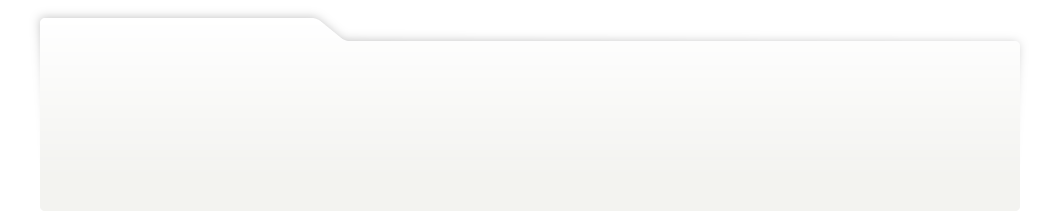
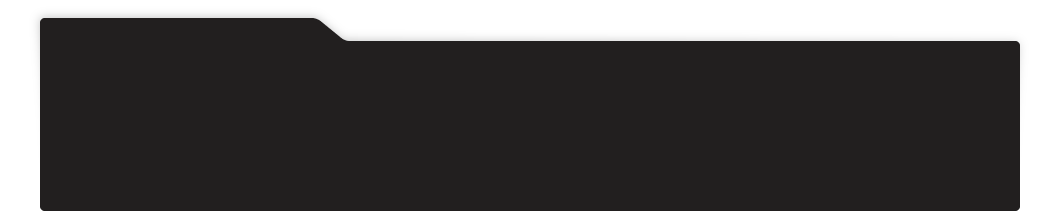
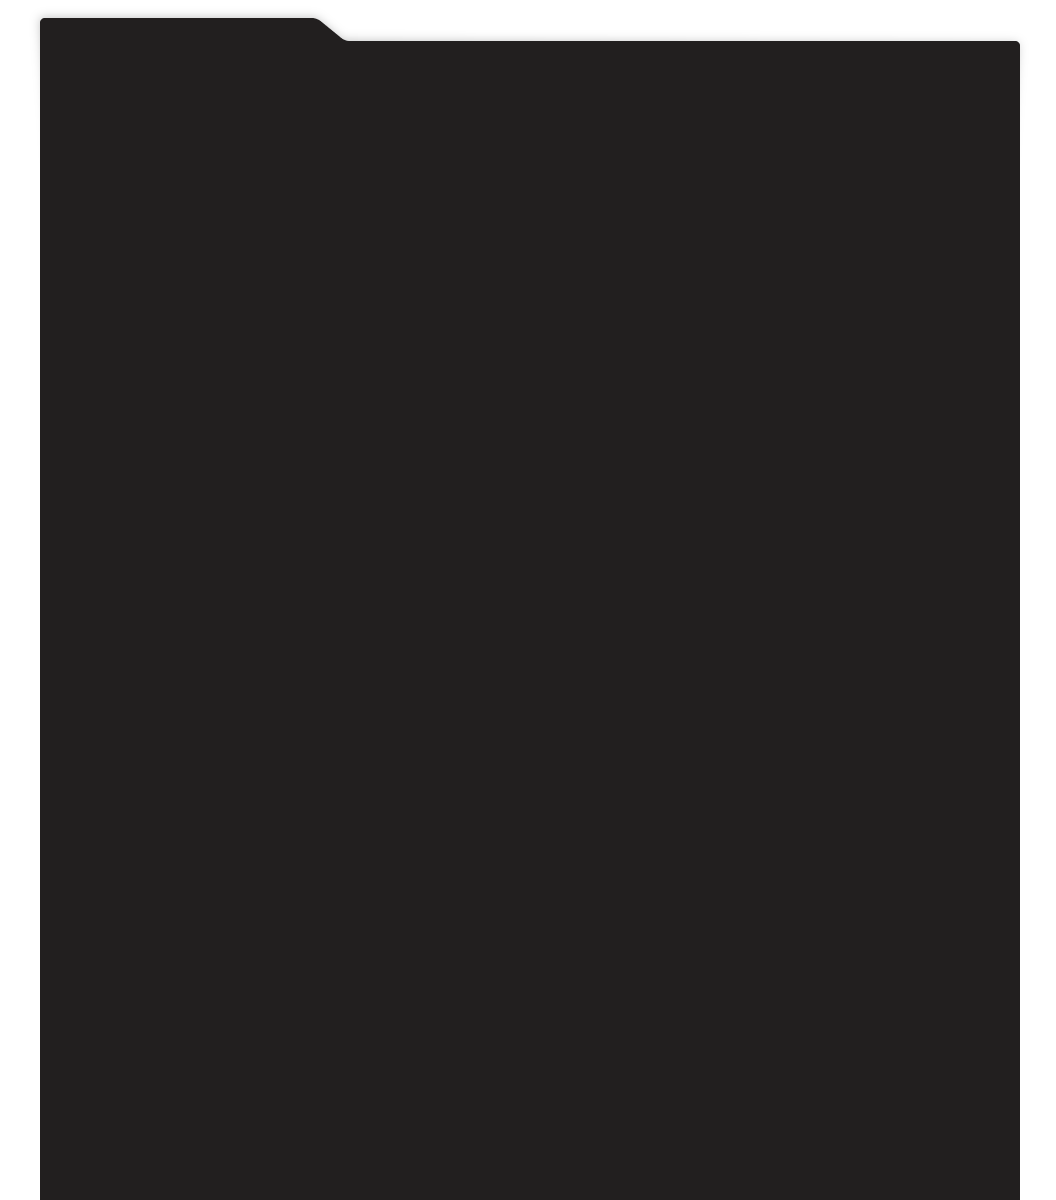
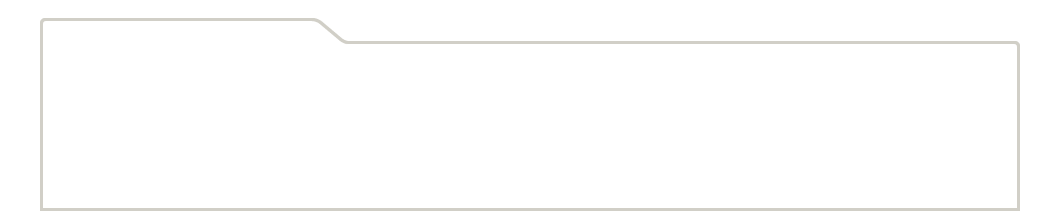
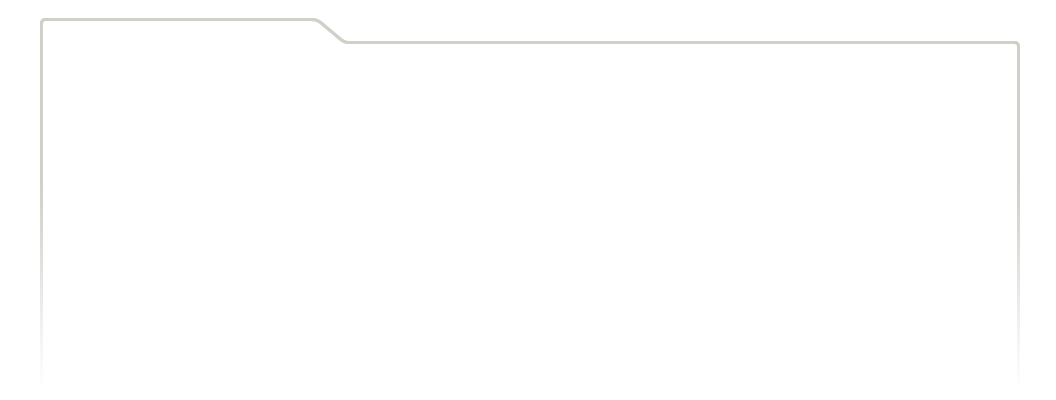
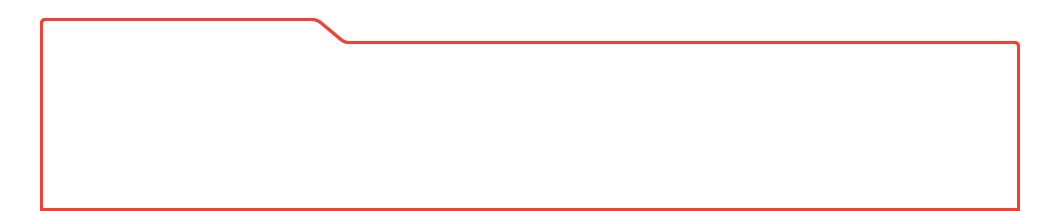
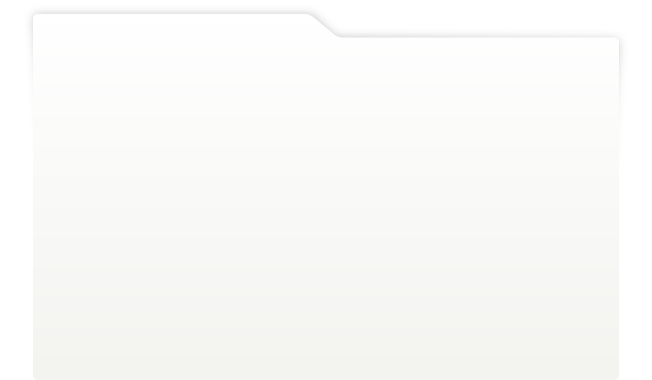
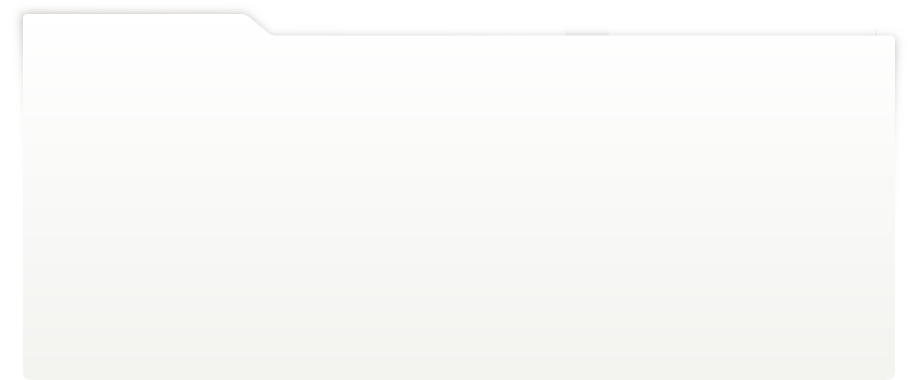
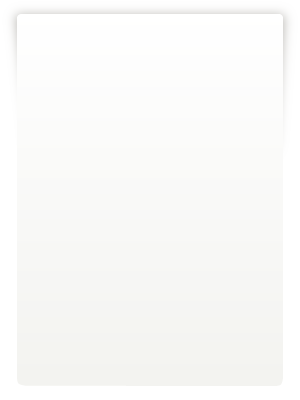
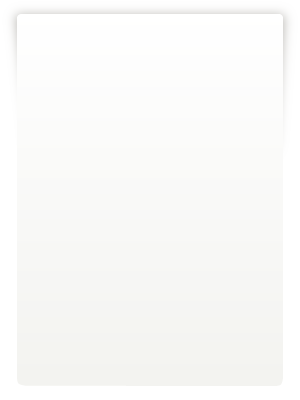
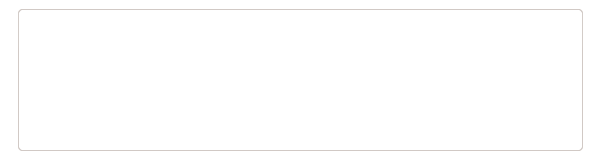
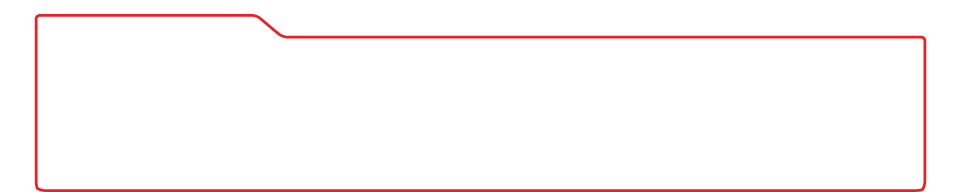
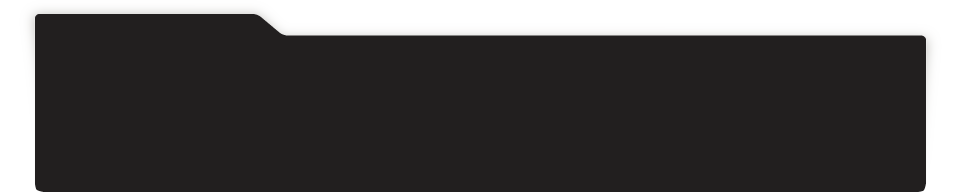
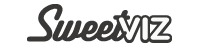
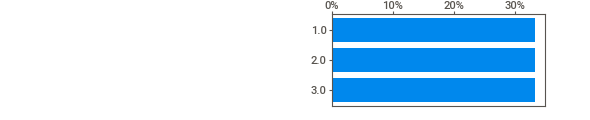
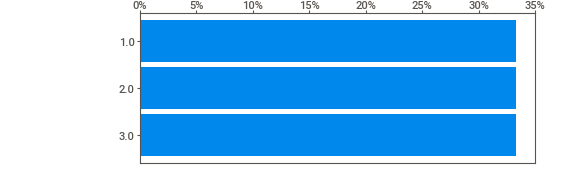
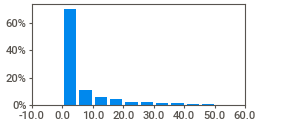
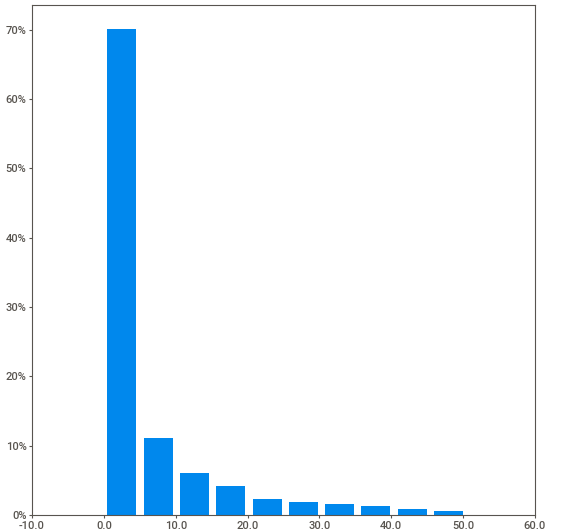
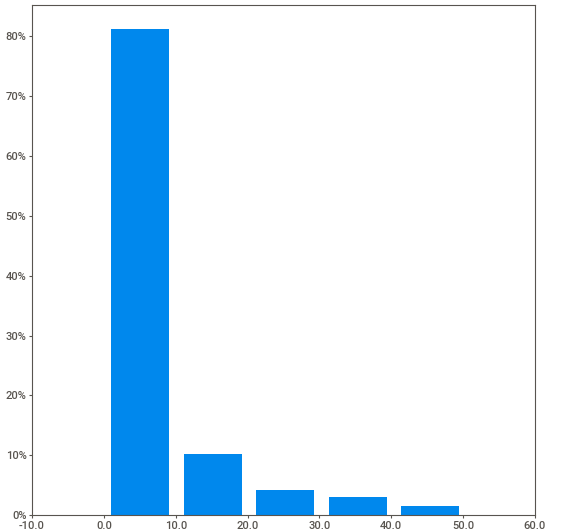
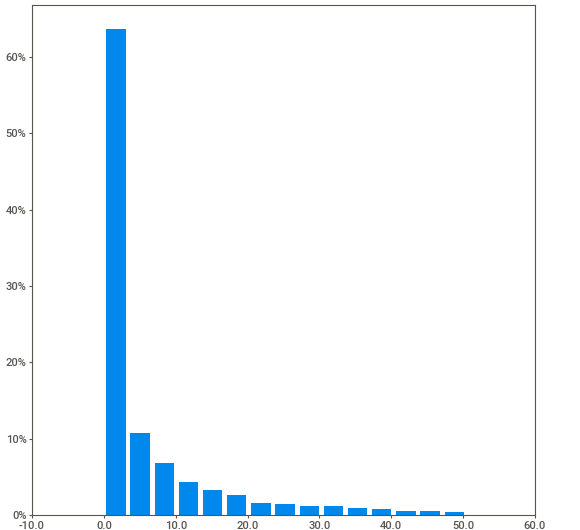
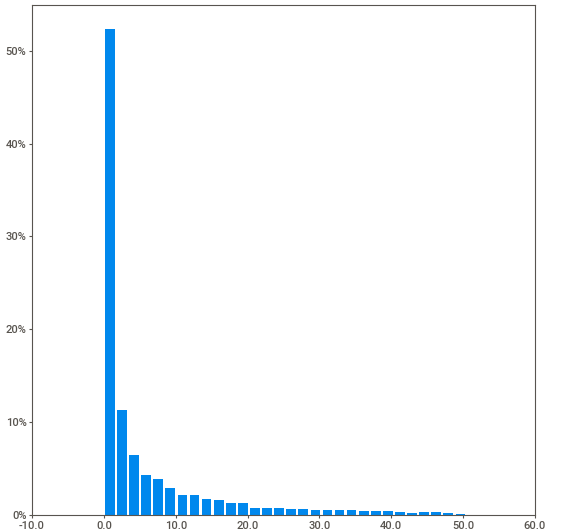
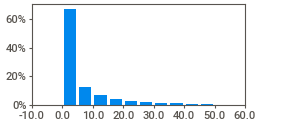
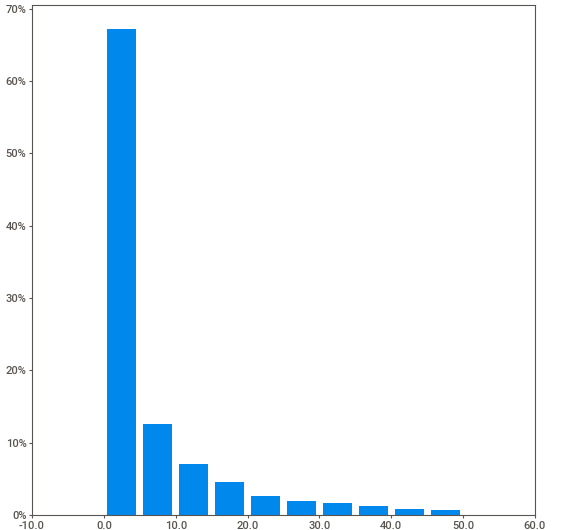
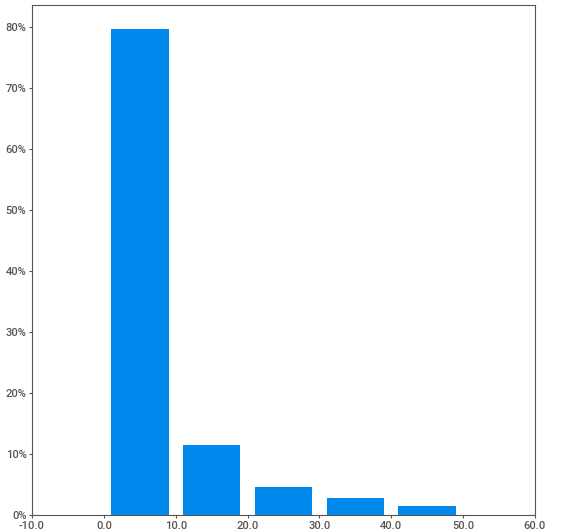
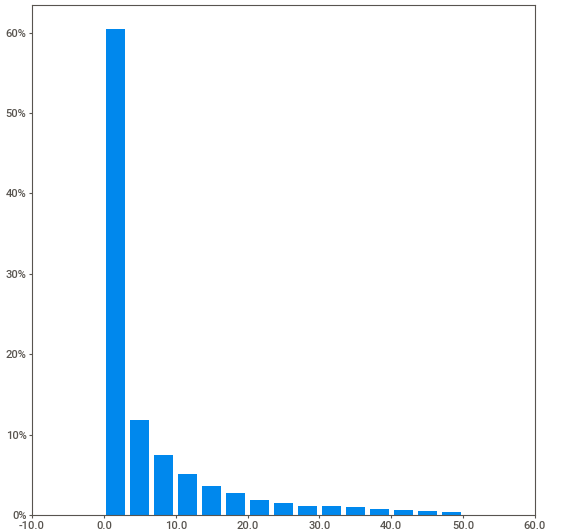
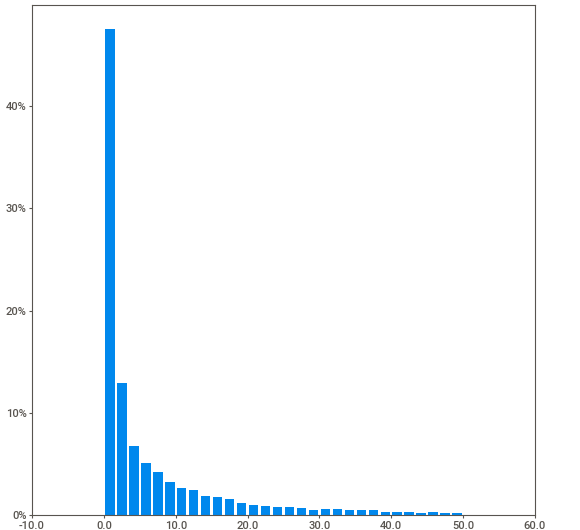
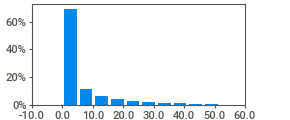
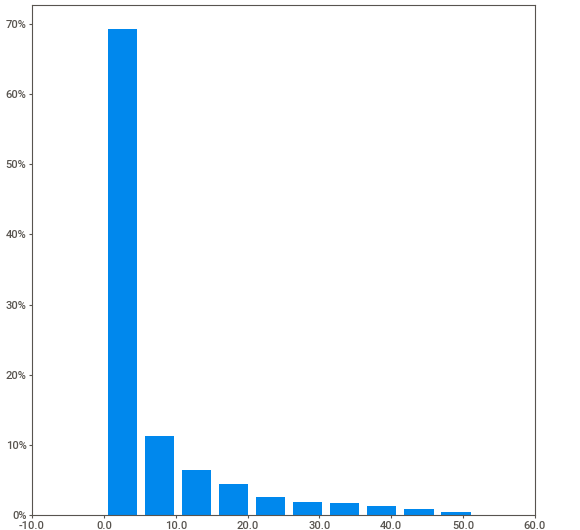
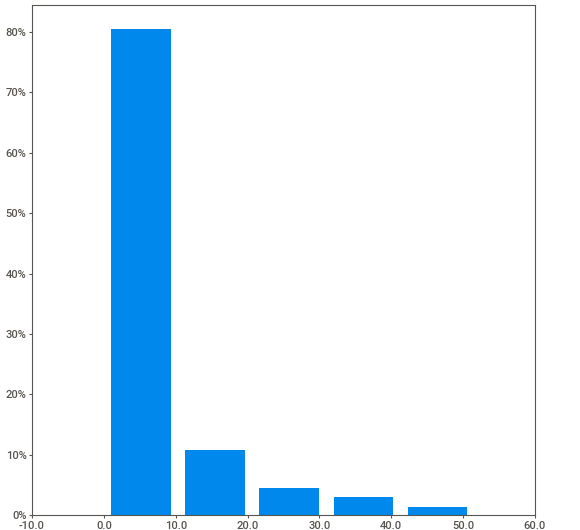
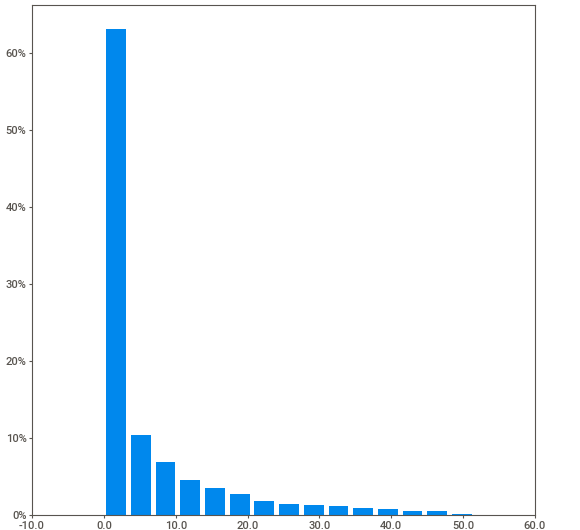
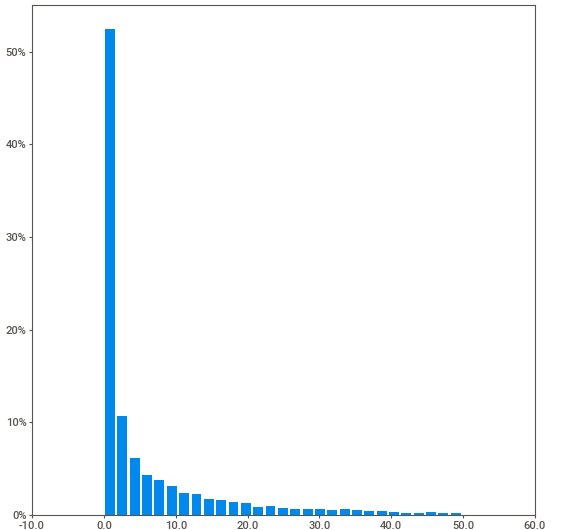
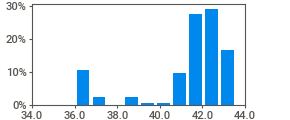
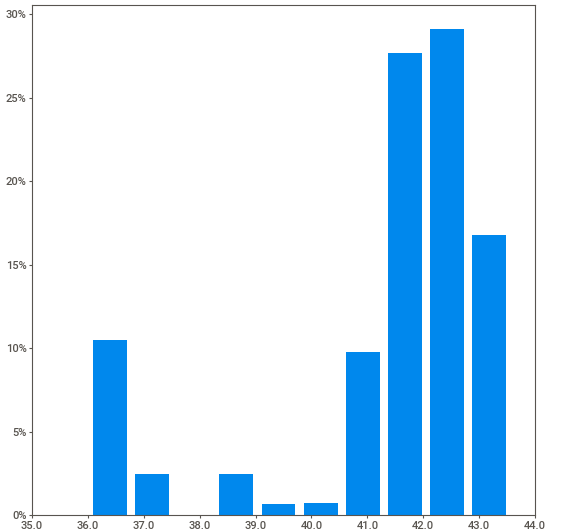
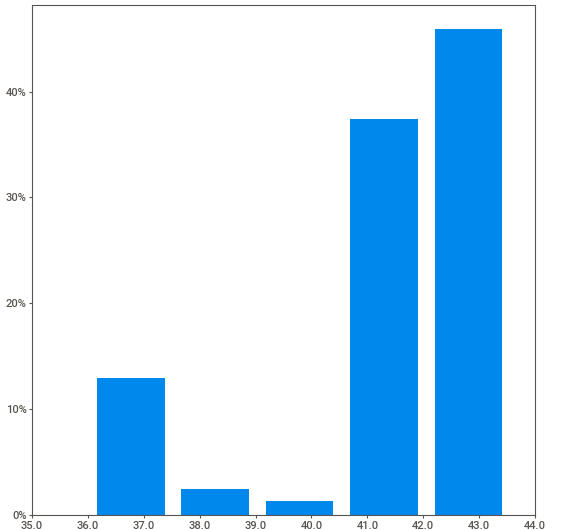
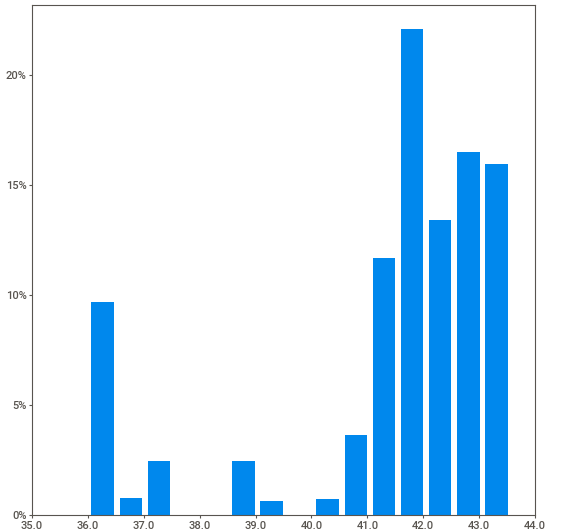
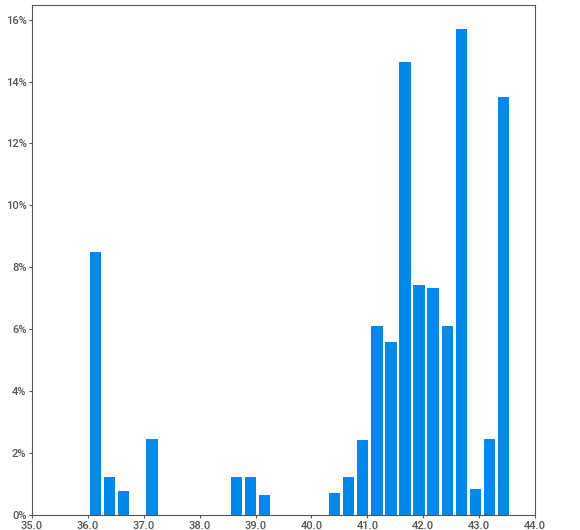
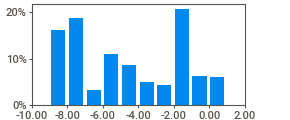
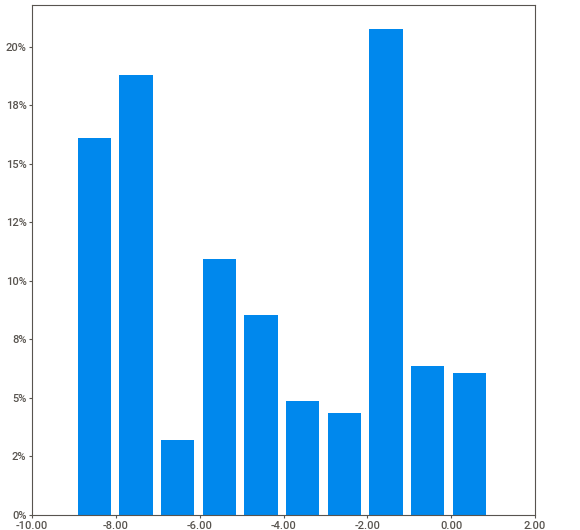
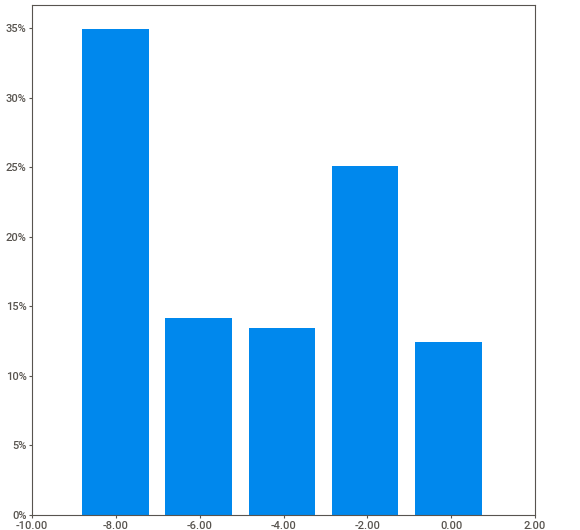
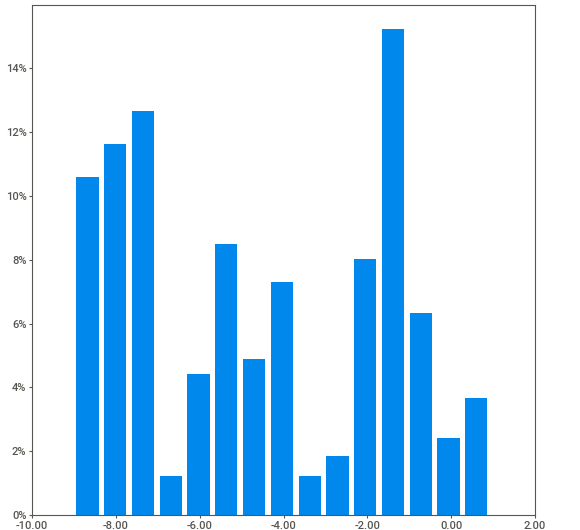
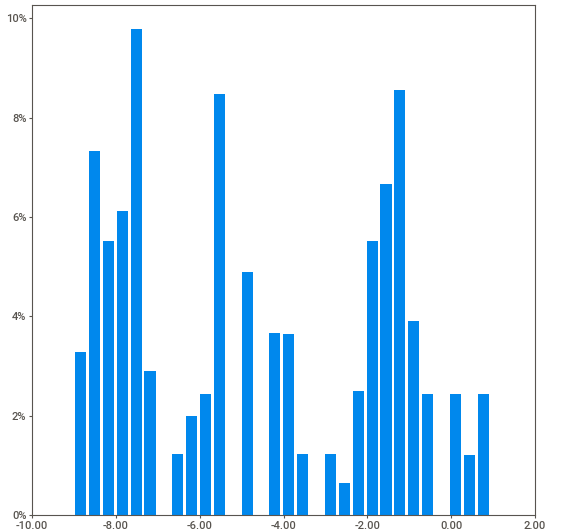
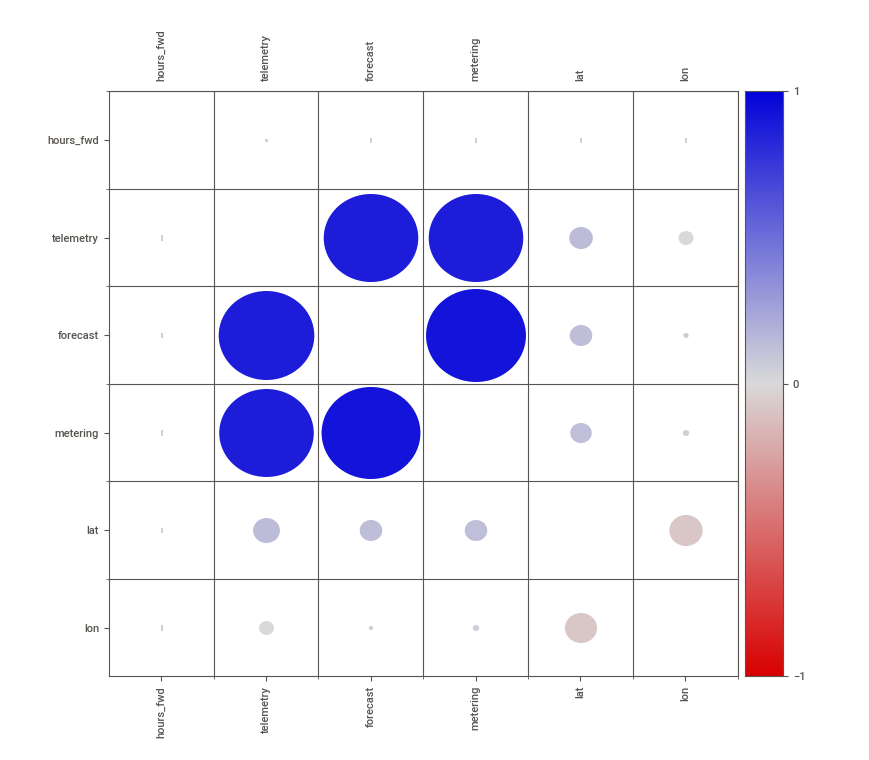
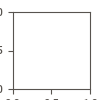

Report 'premaster.html' was saved to storage.


In [52]:
advert_report.show_notebook(filepath='premaster.html')


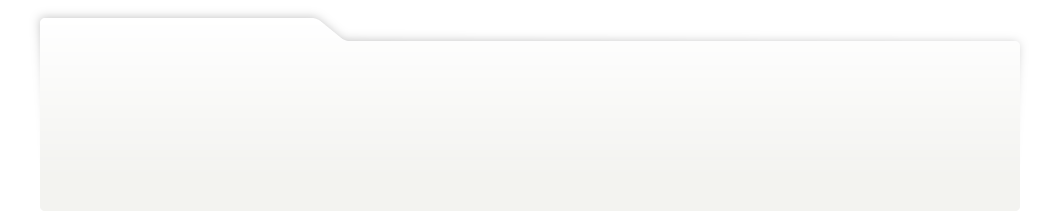
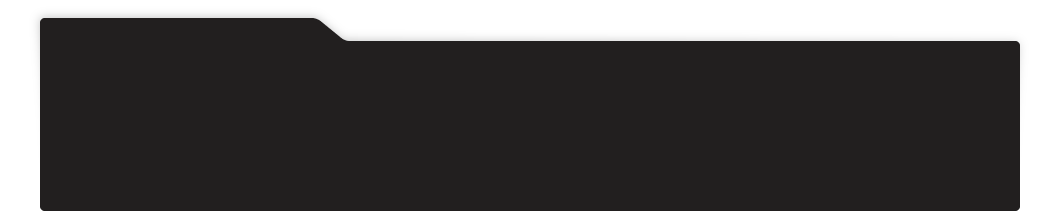
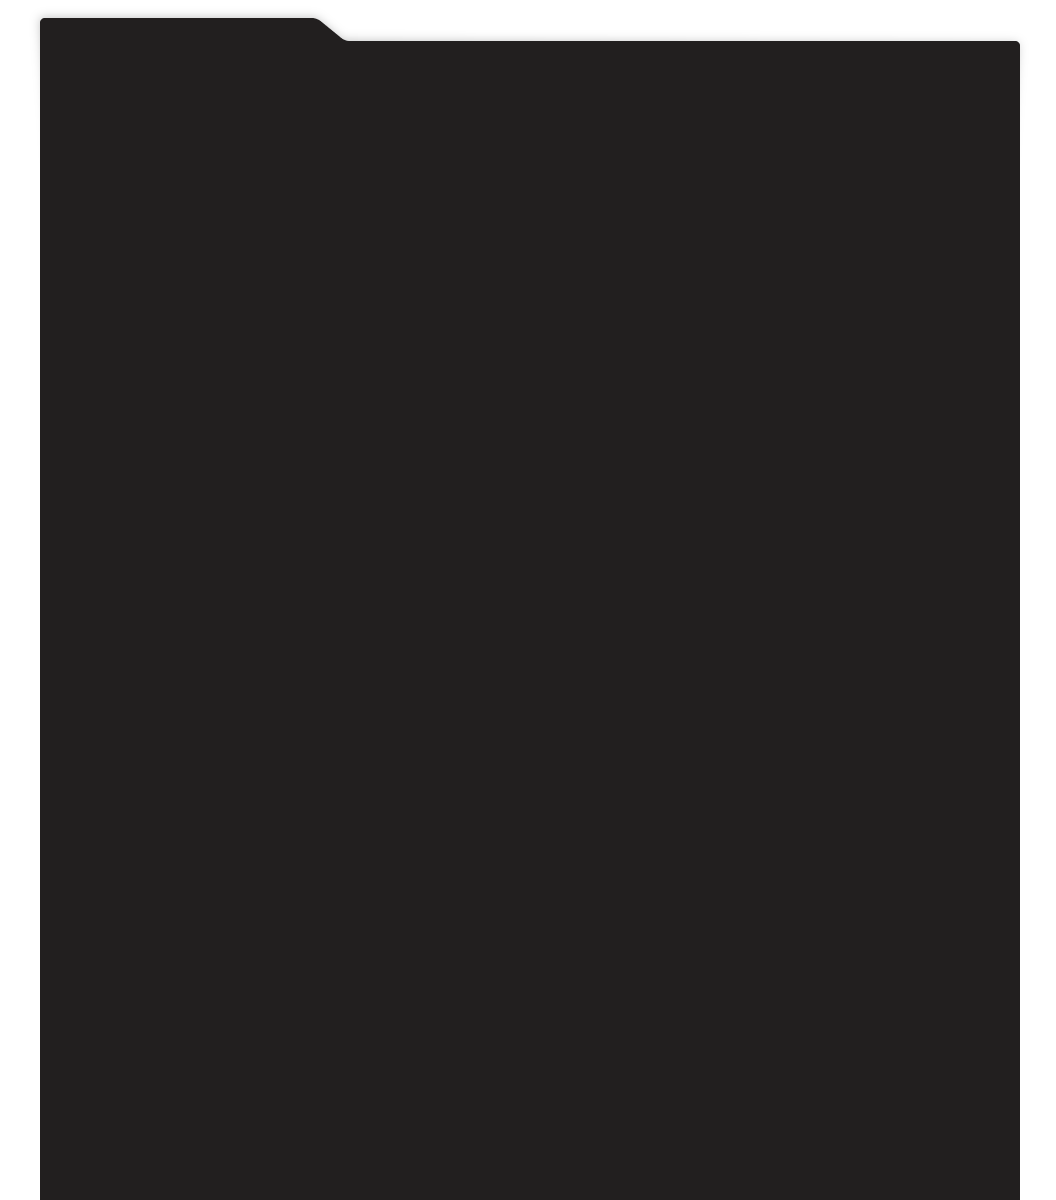
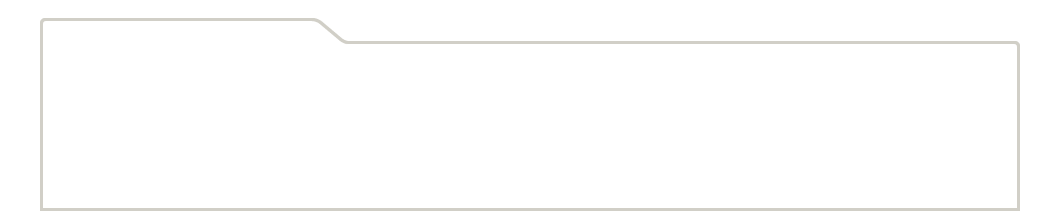
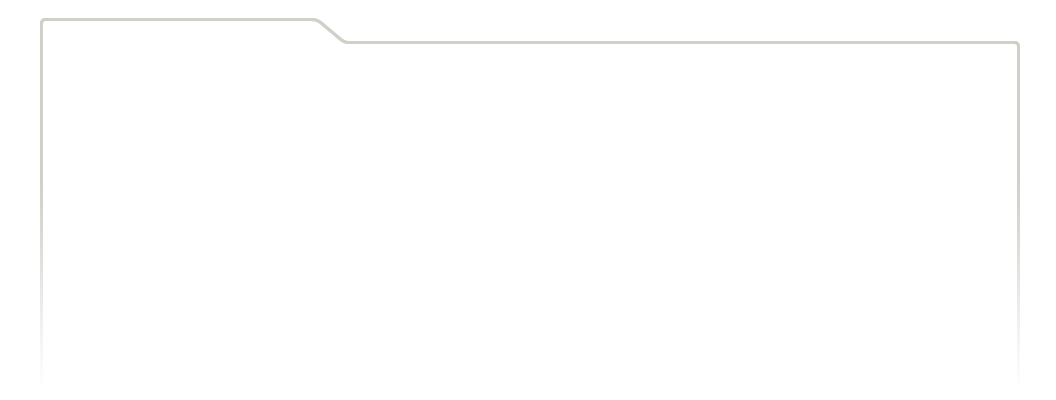
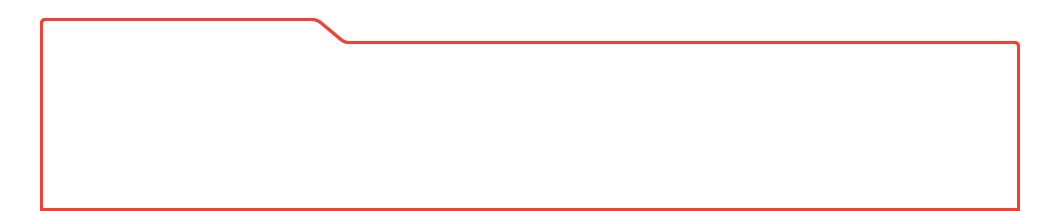
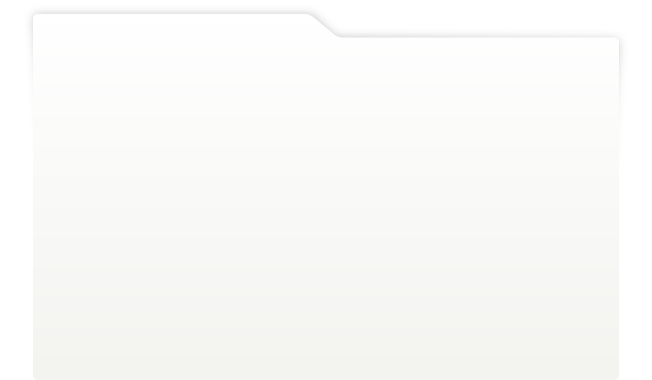
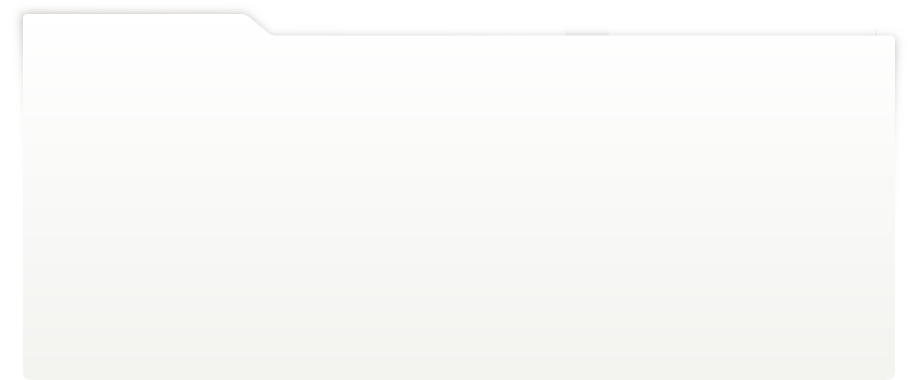
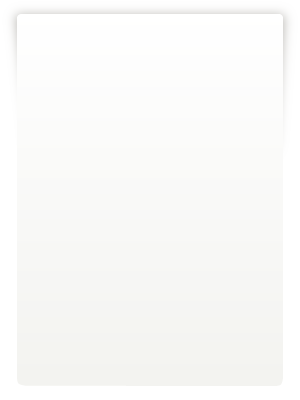
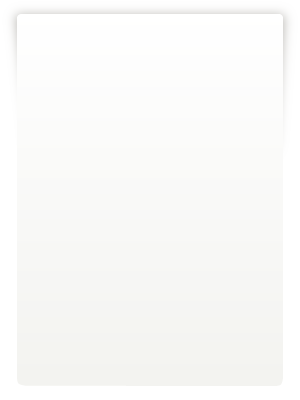
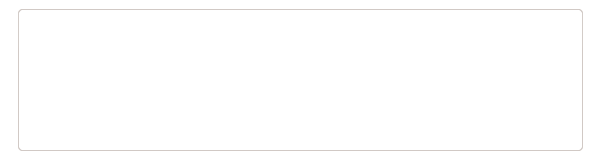
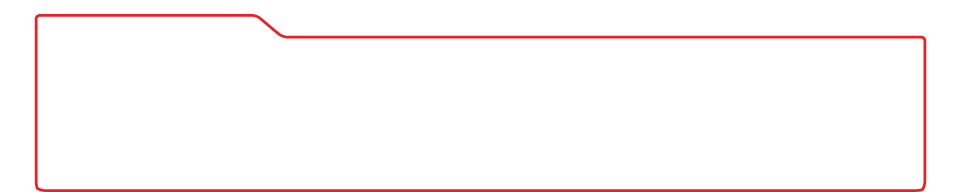
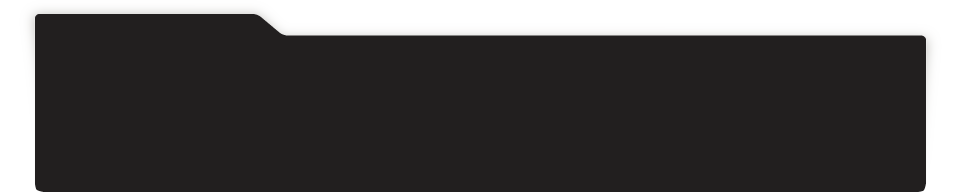
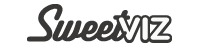
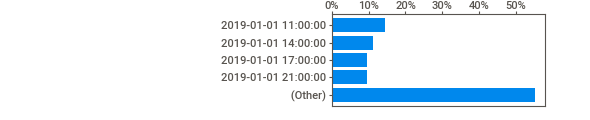
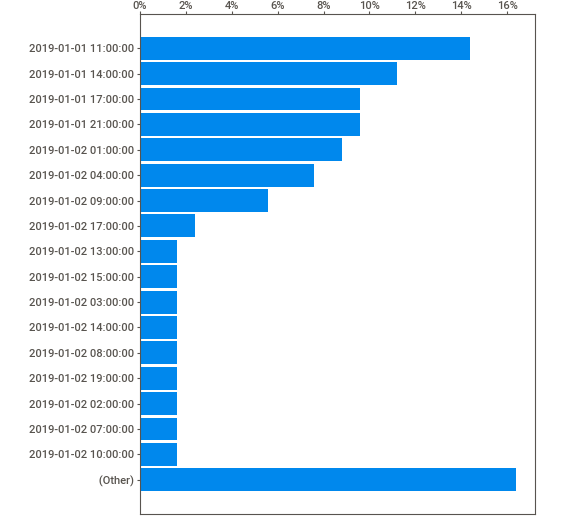
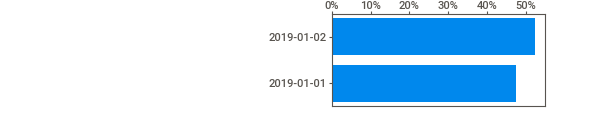
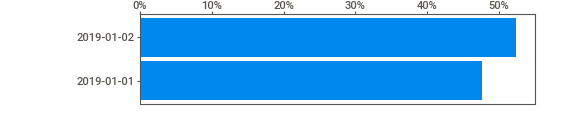
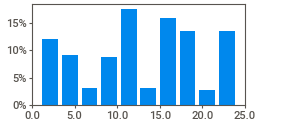
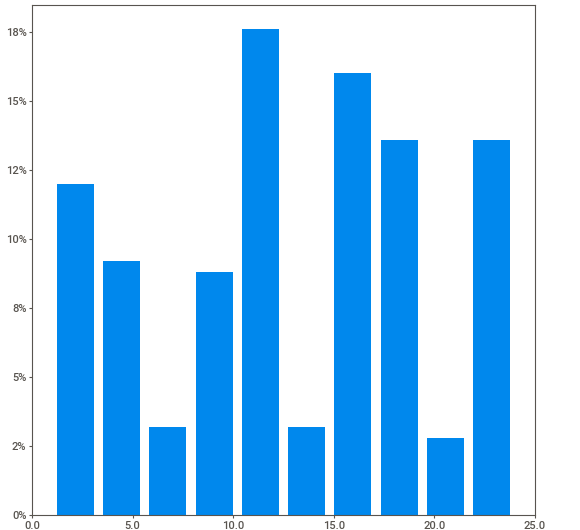
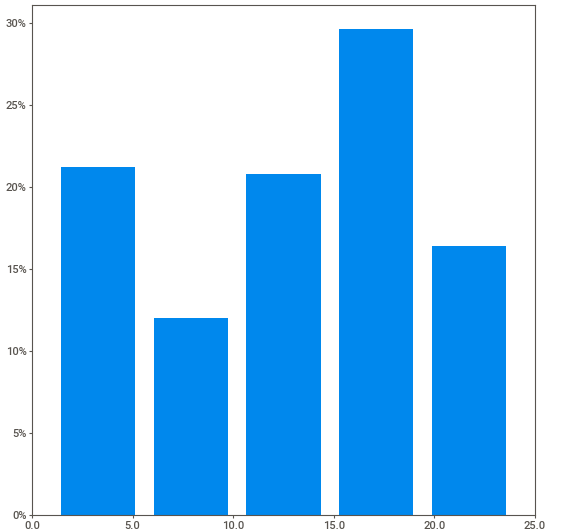
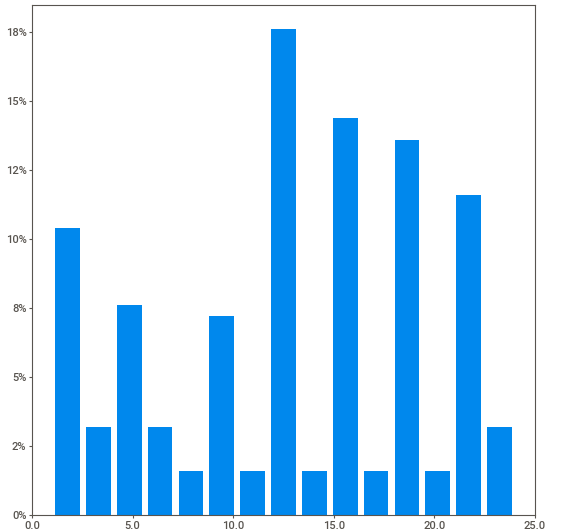
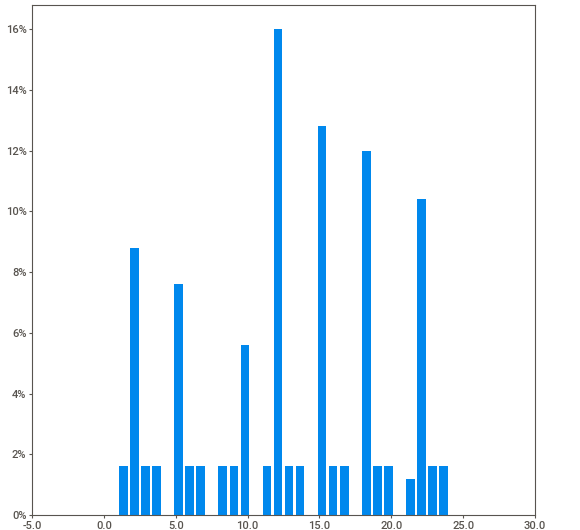
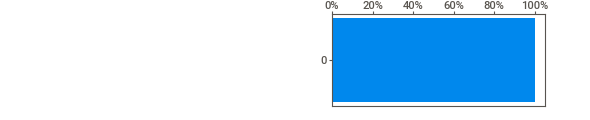
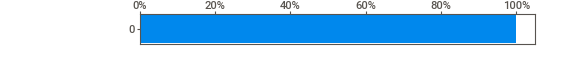
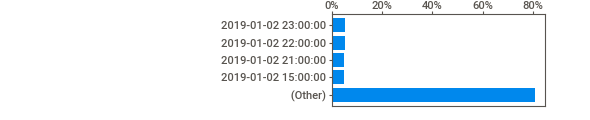
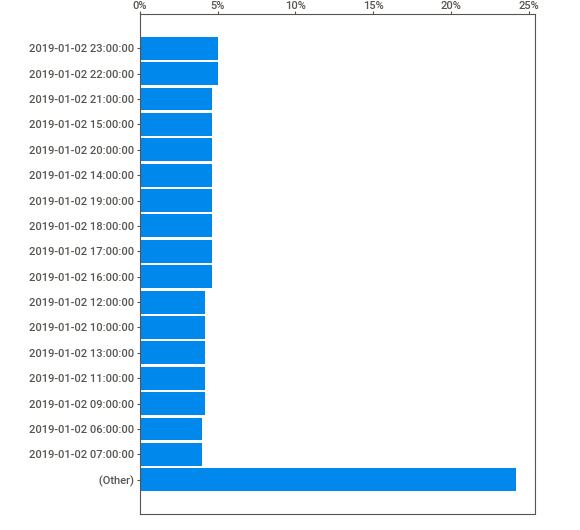
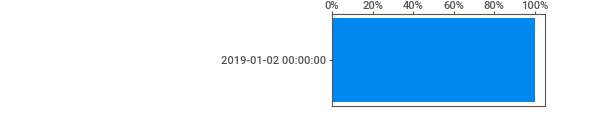
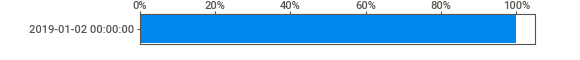
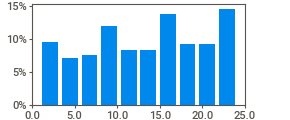
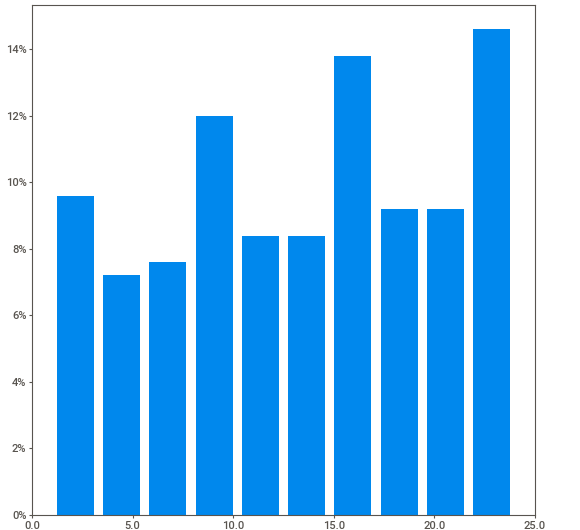
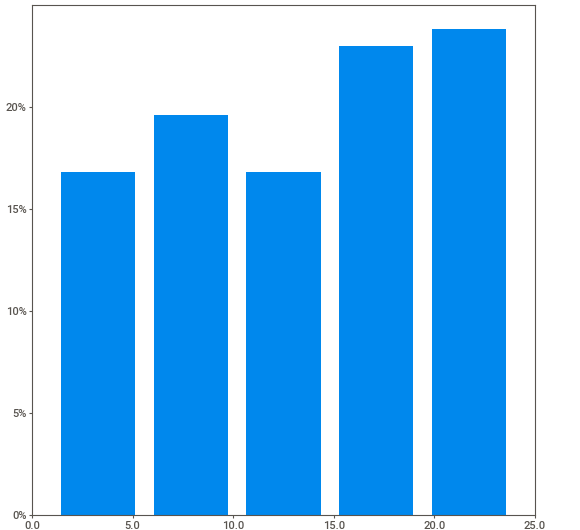
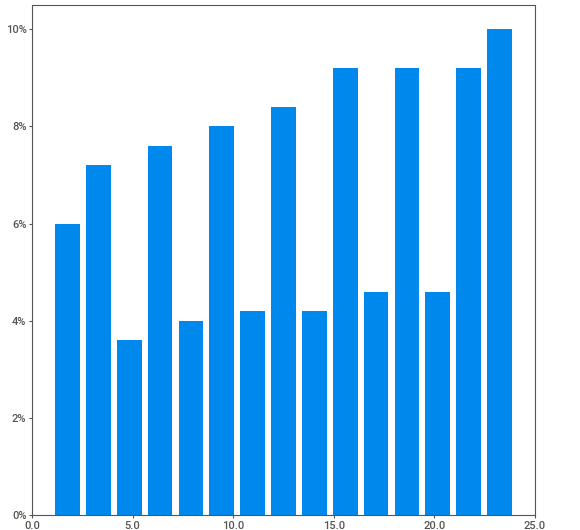
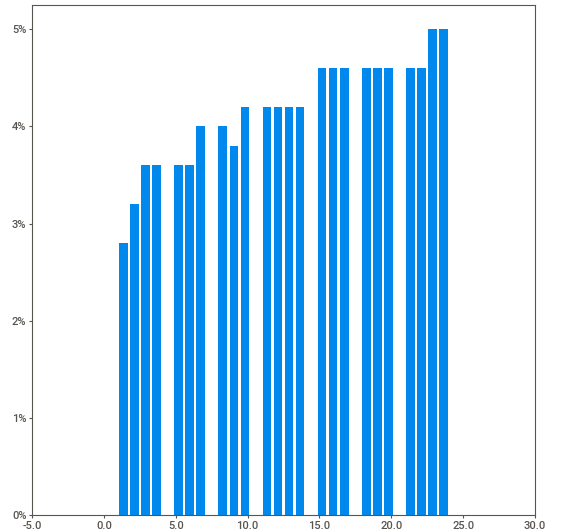
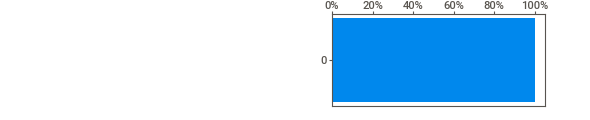
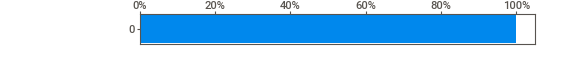
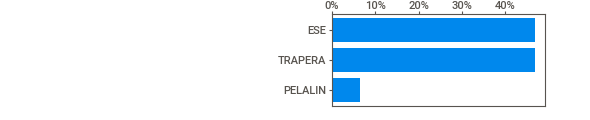
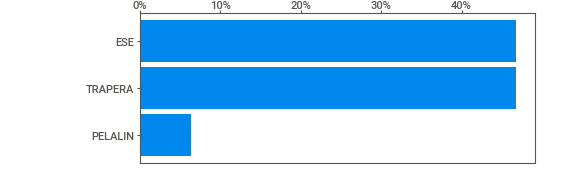
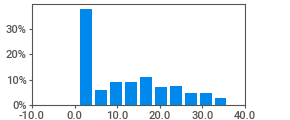
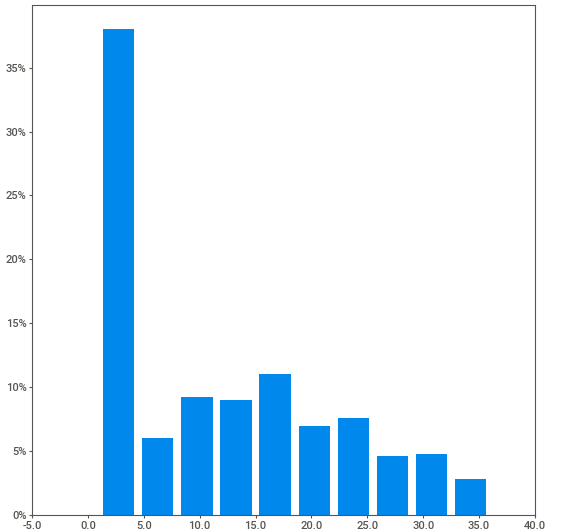
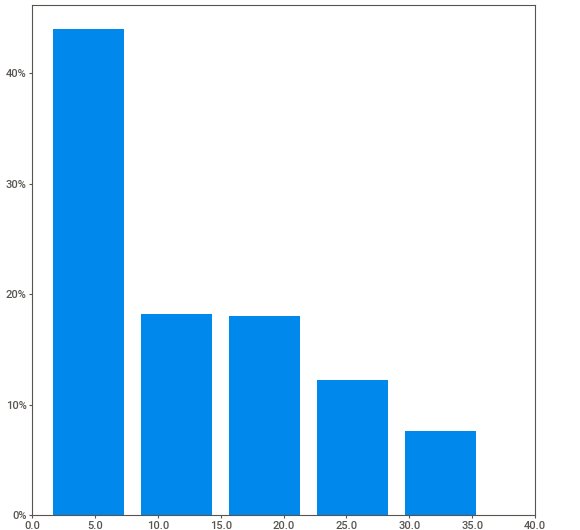
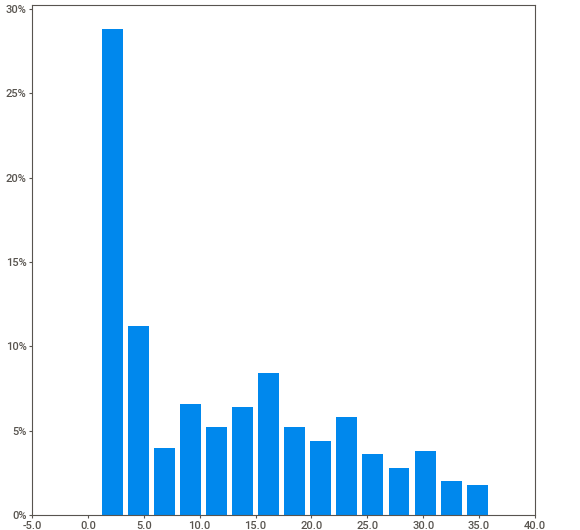
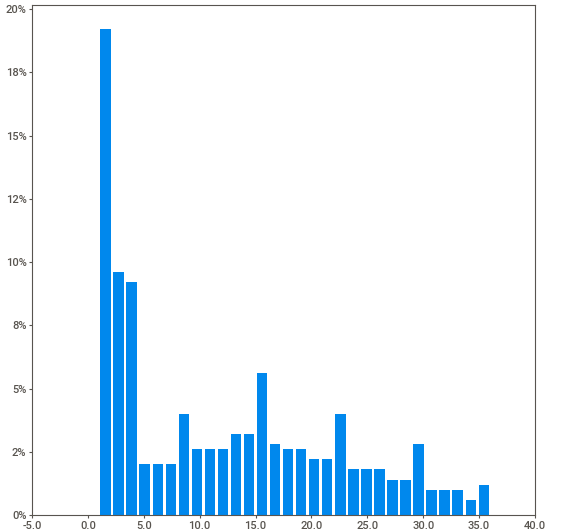
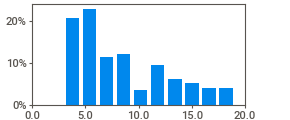
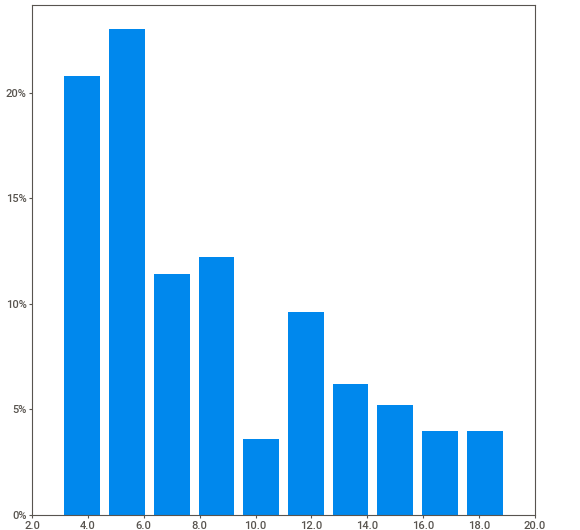
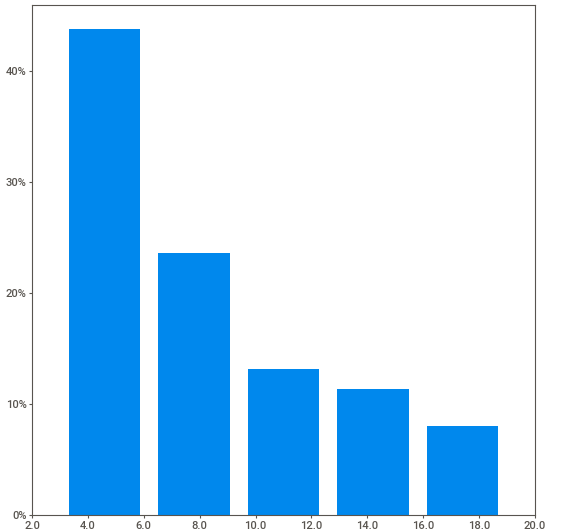
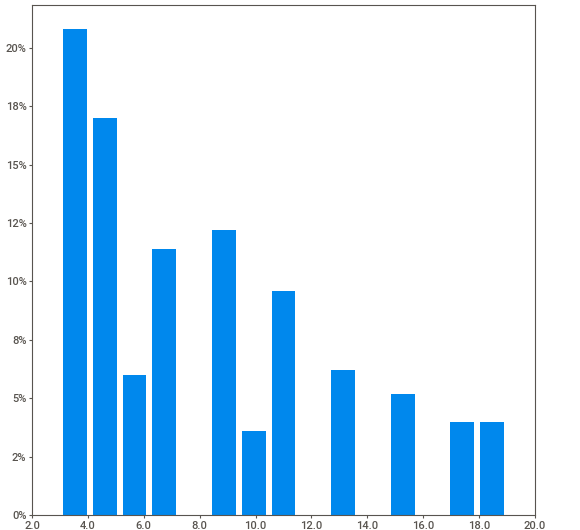
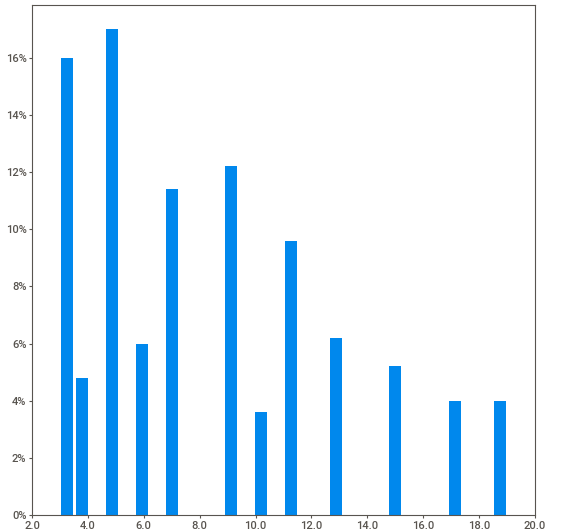
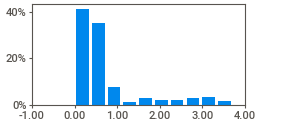
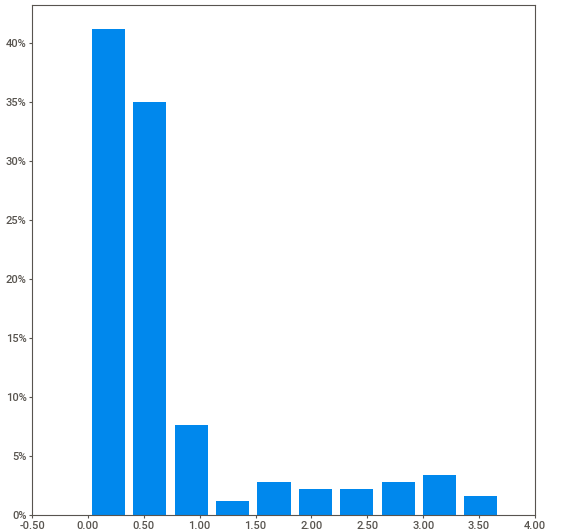
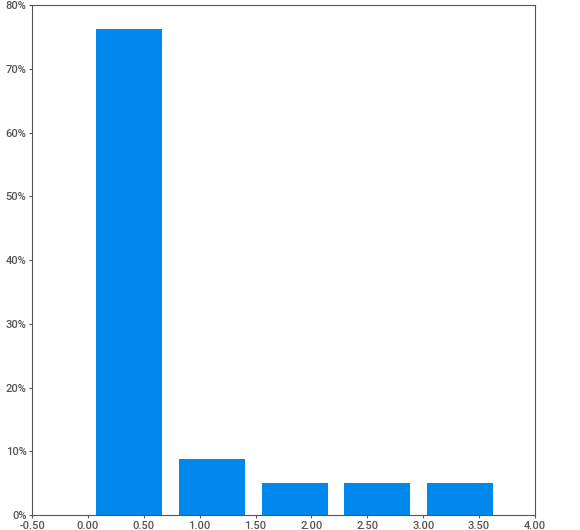
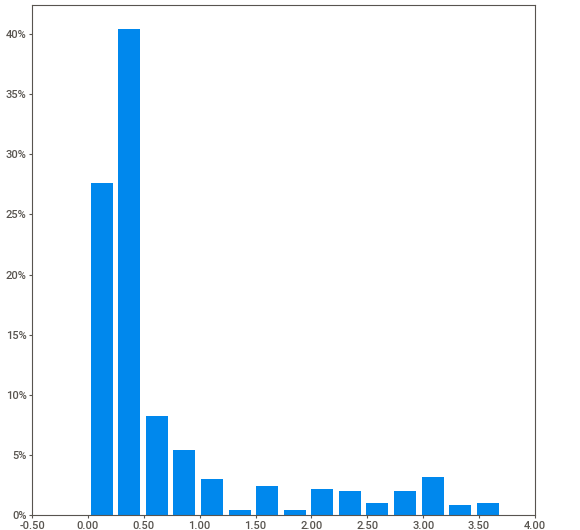
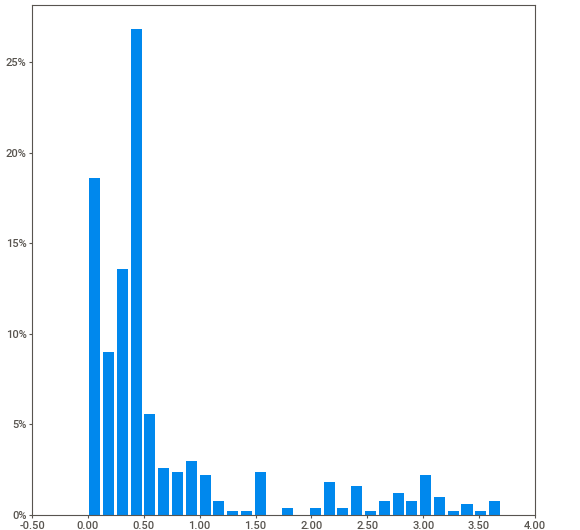
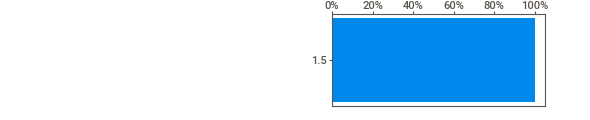
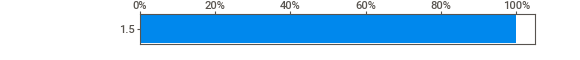
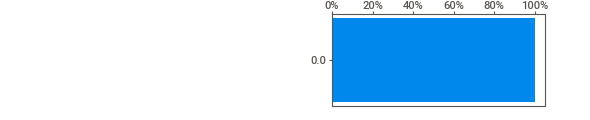
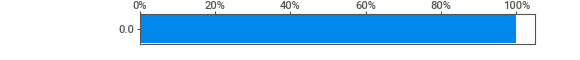
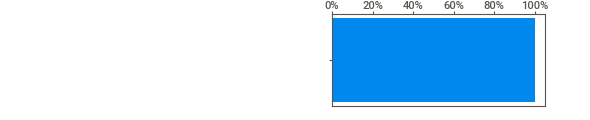
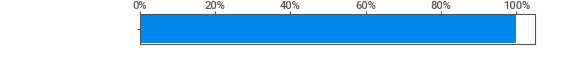
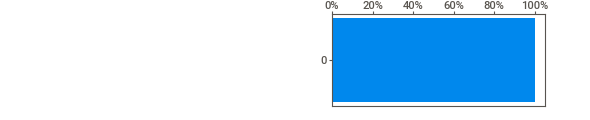
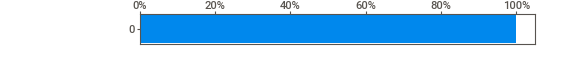
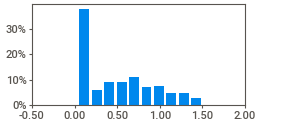
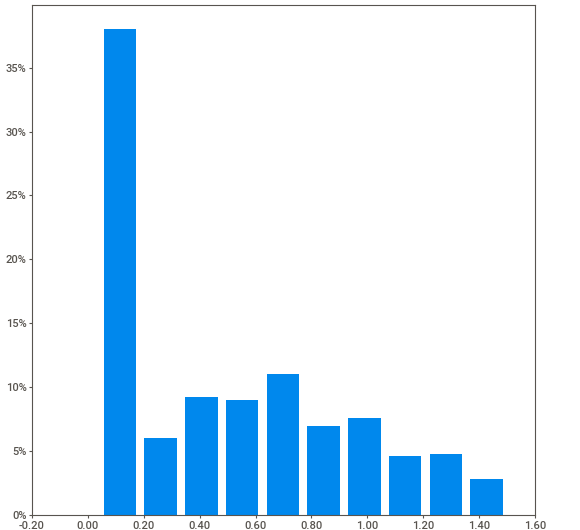
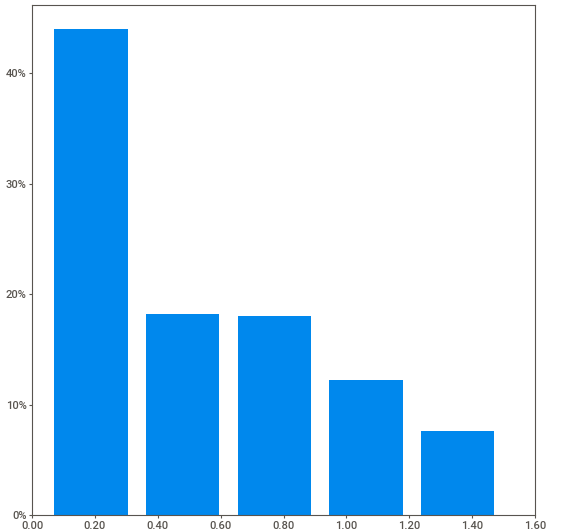
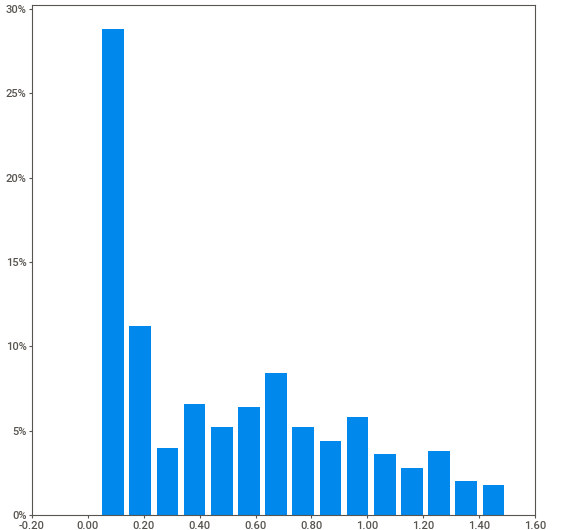
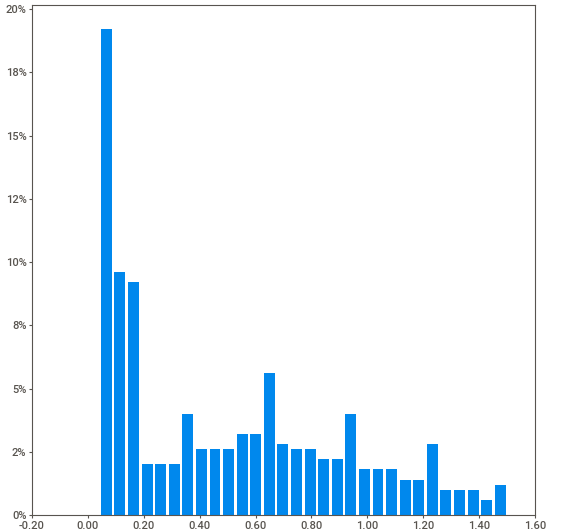
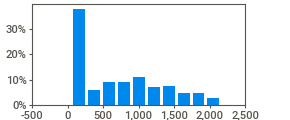
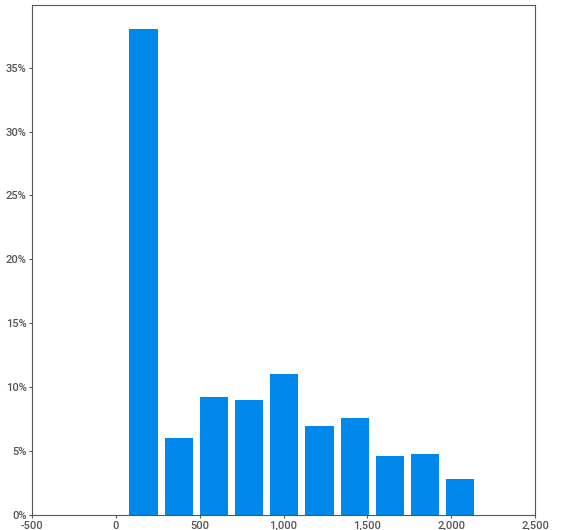
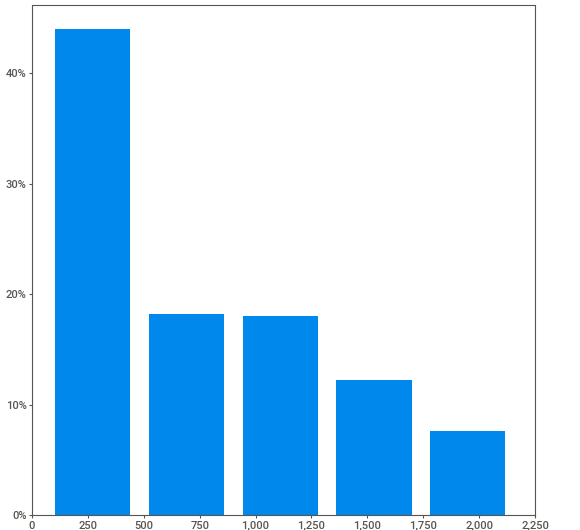
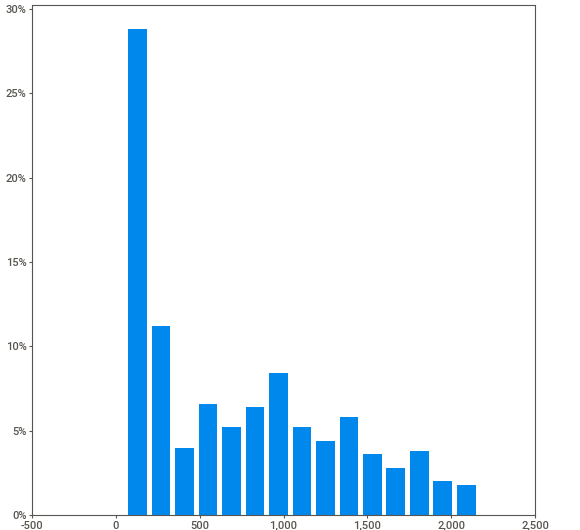
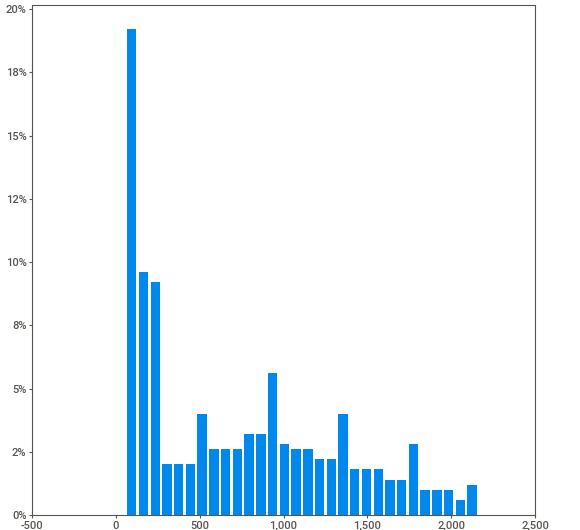
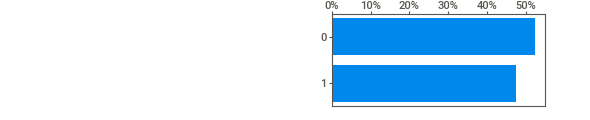
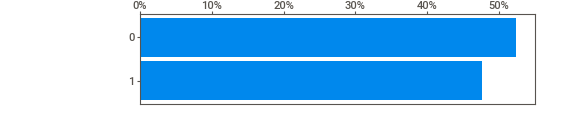
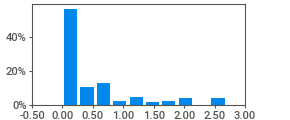
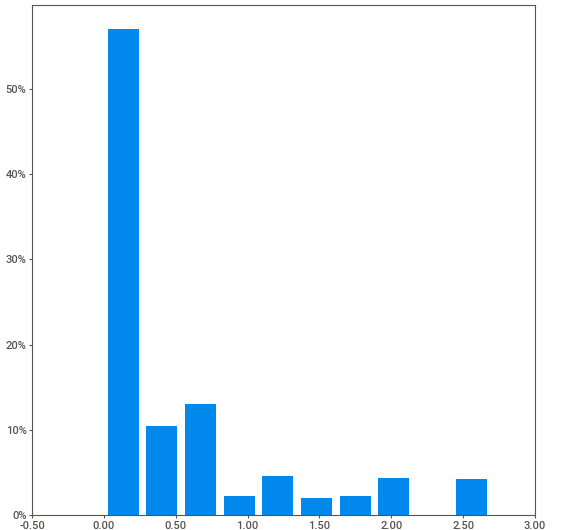
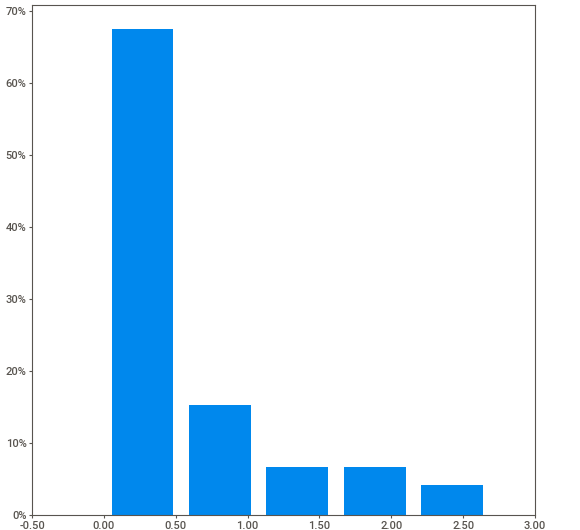
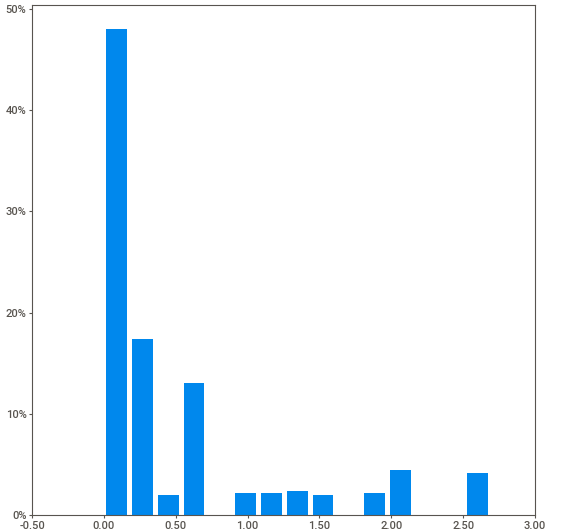
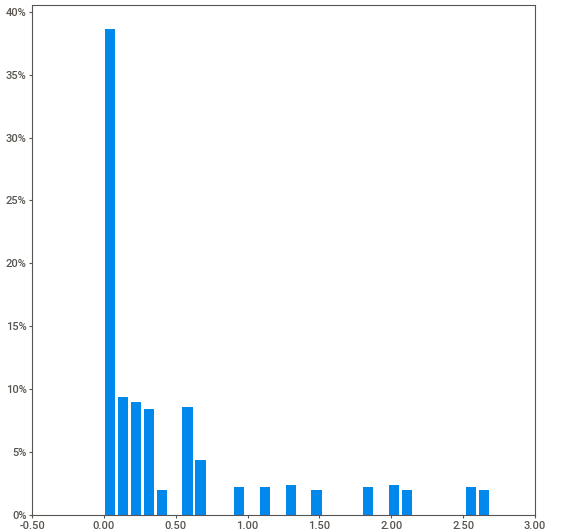
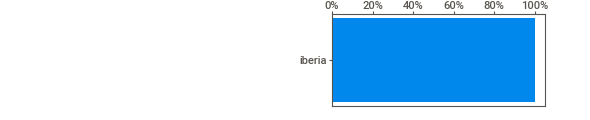
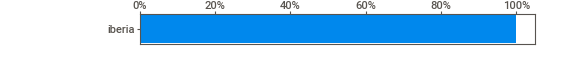
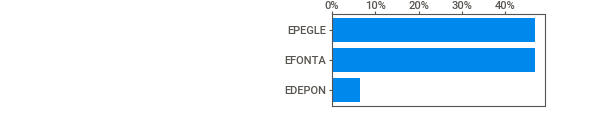
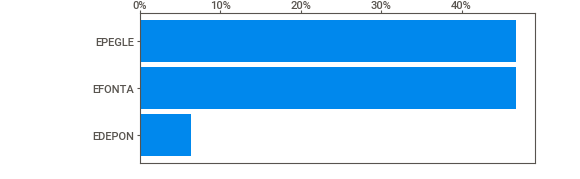
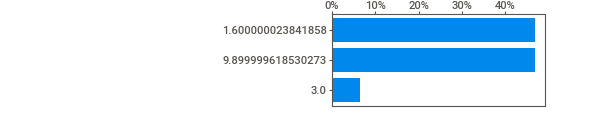
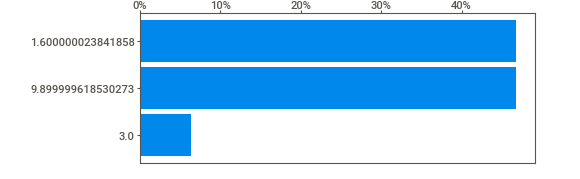
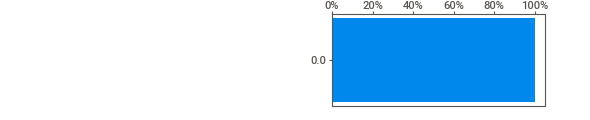
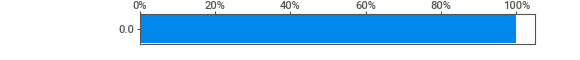
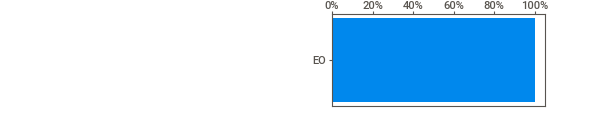
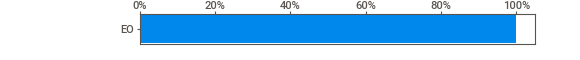
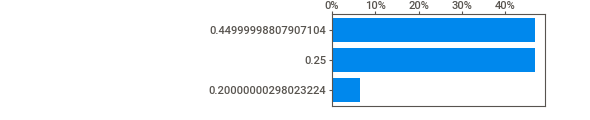
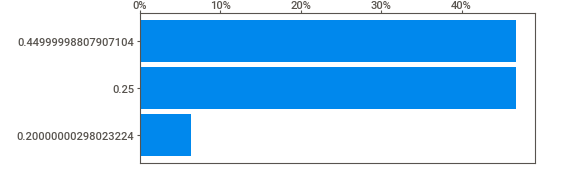
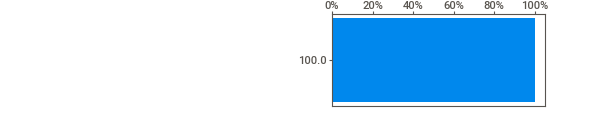
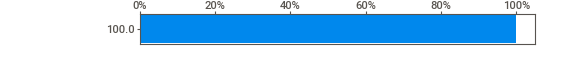
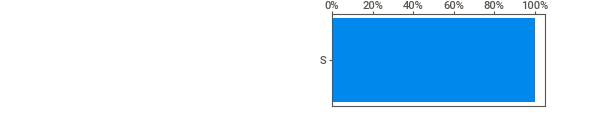
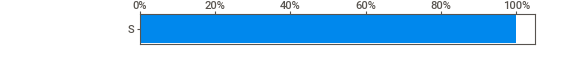
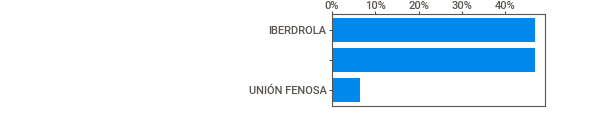
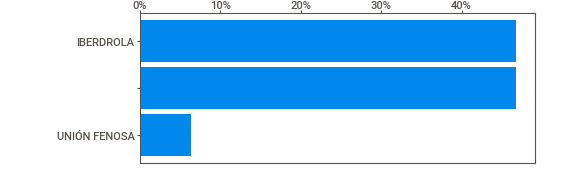
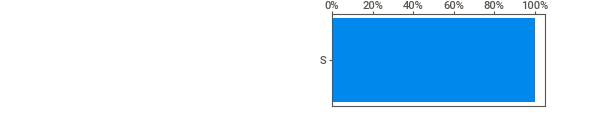
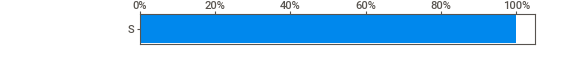
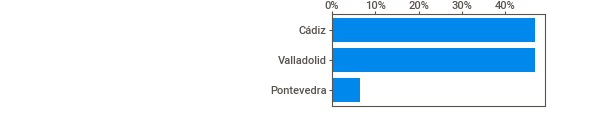
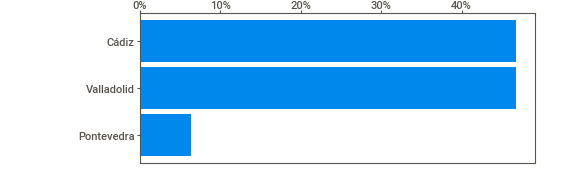
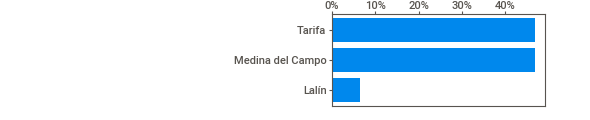
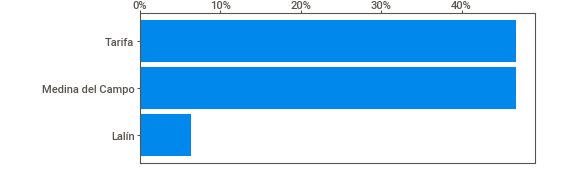
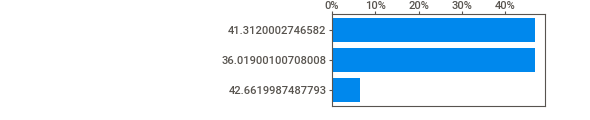
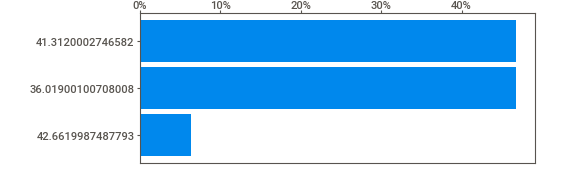
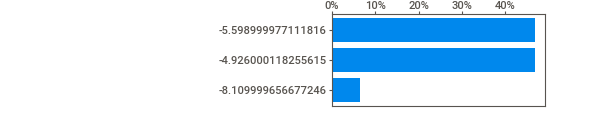
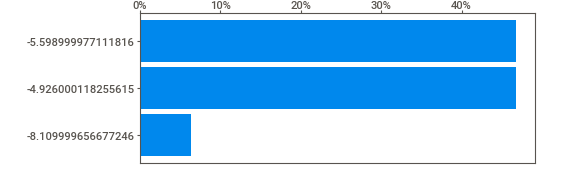
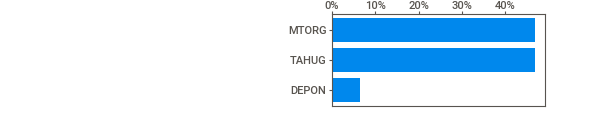
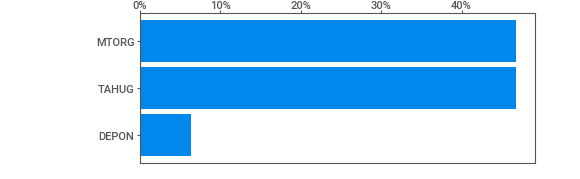
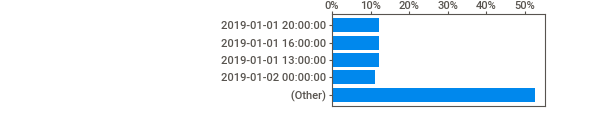
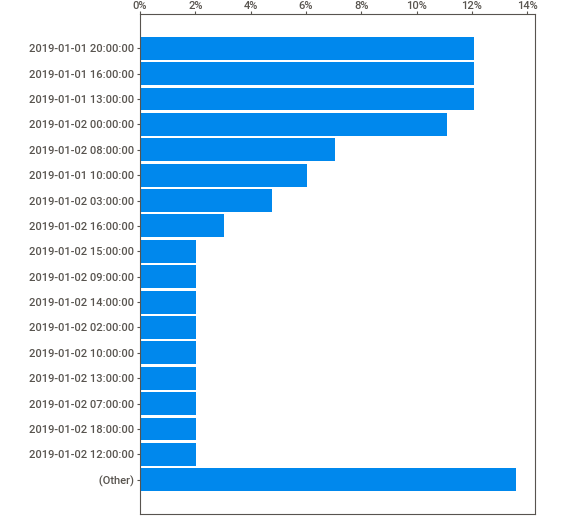
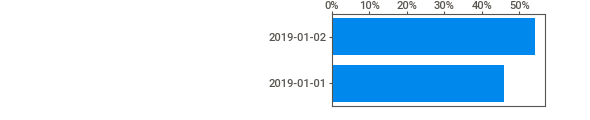
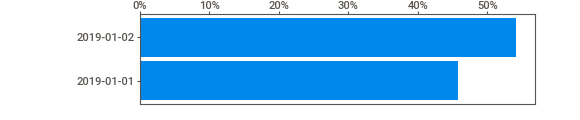
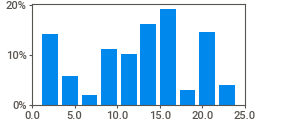
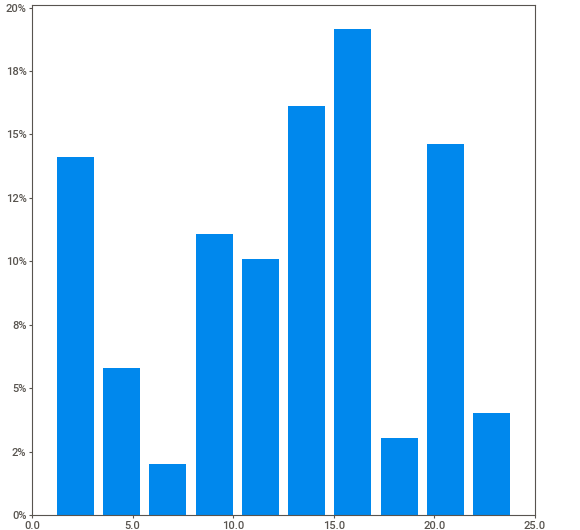
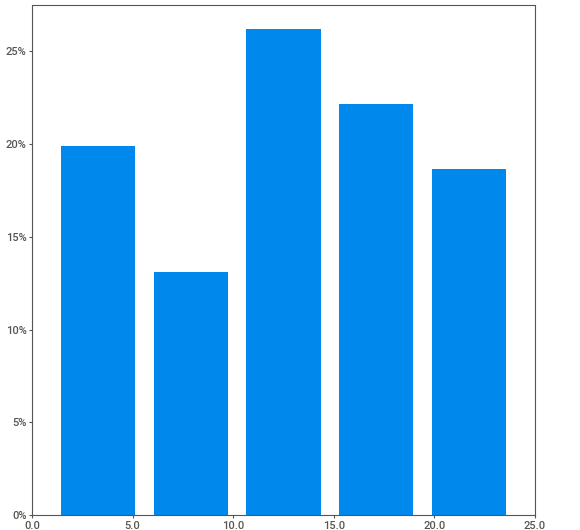
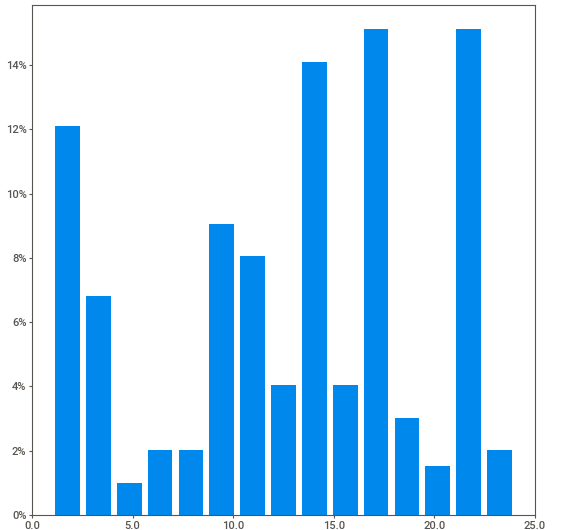
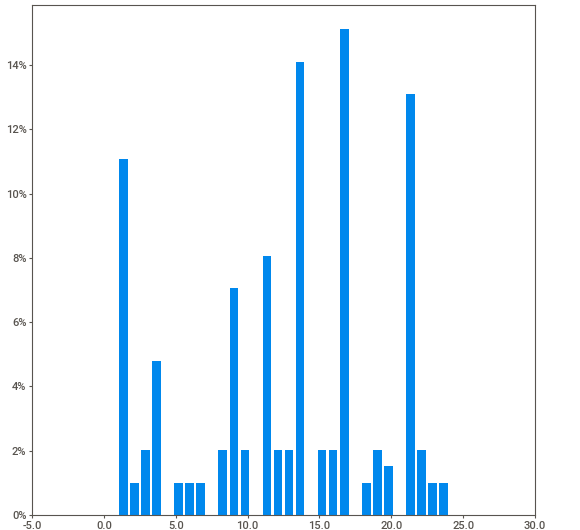
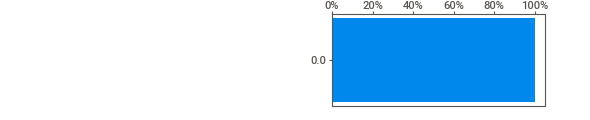
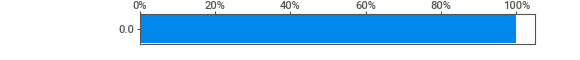
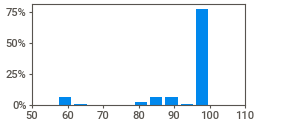
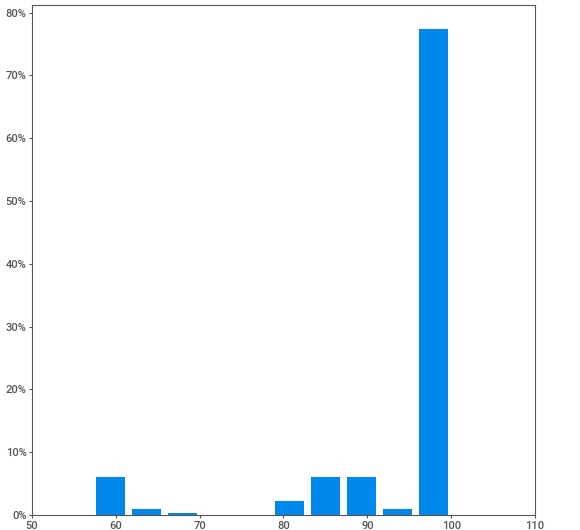
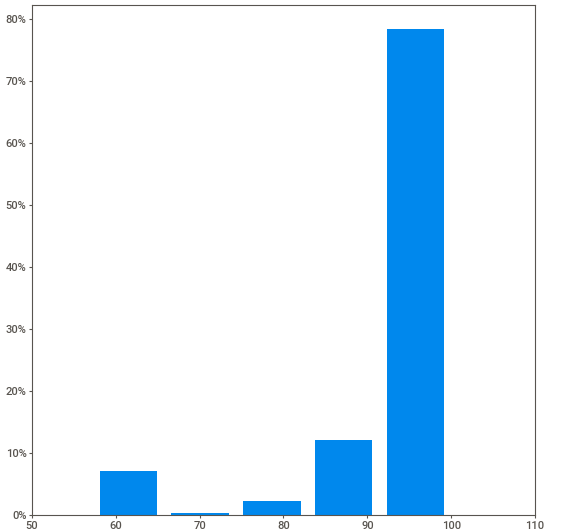
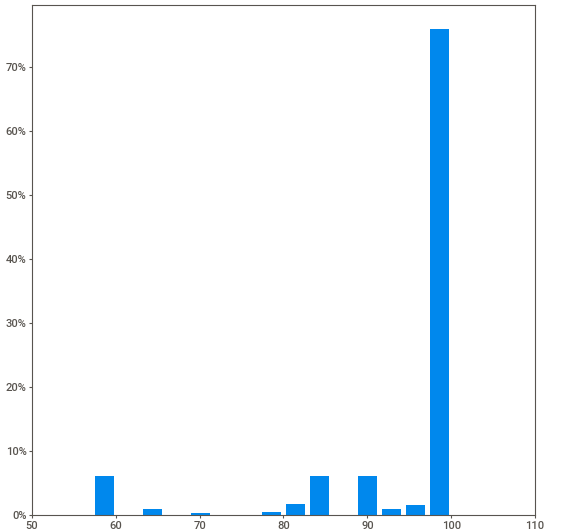
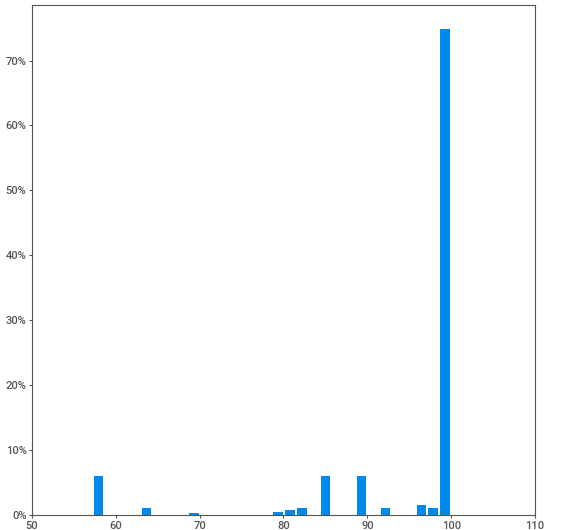
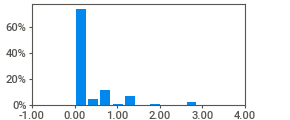
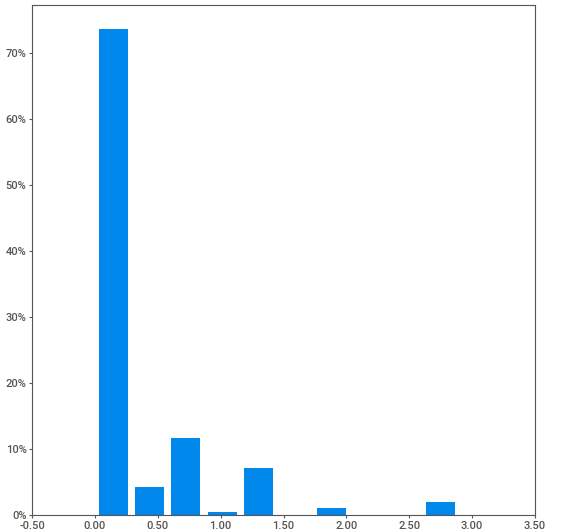
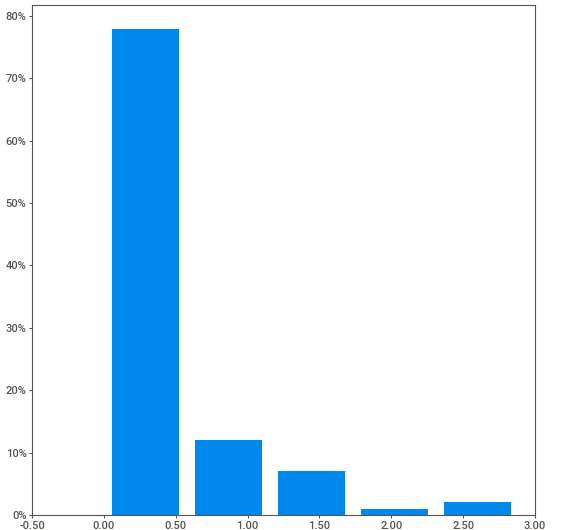
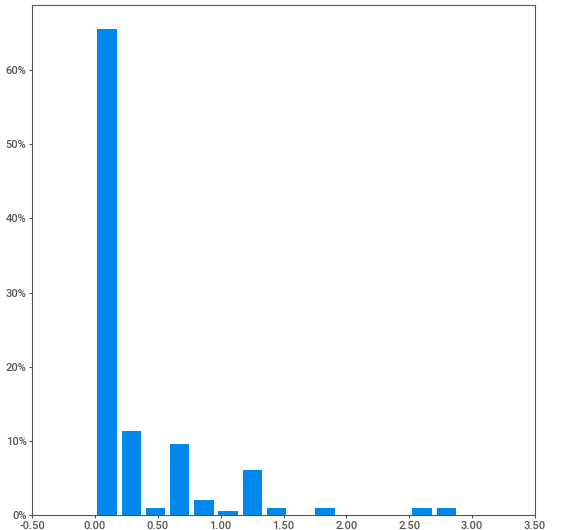
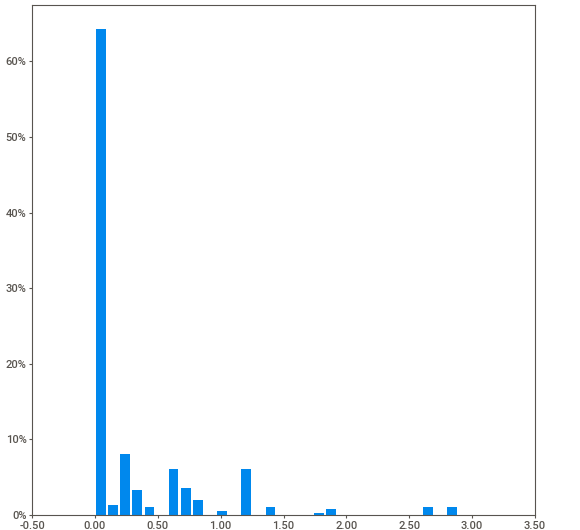
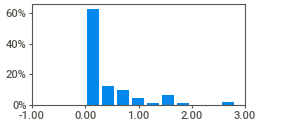
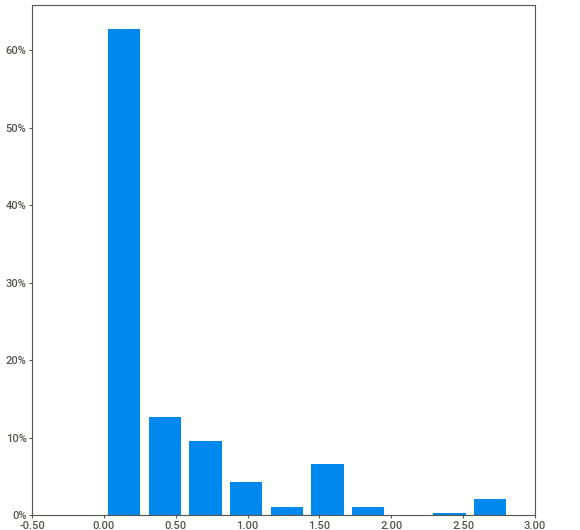
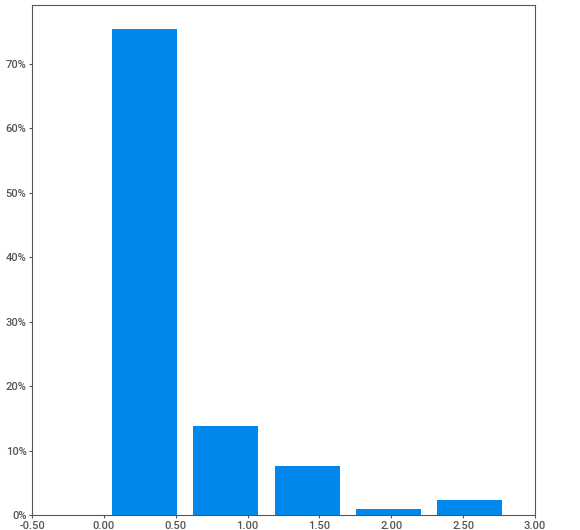
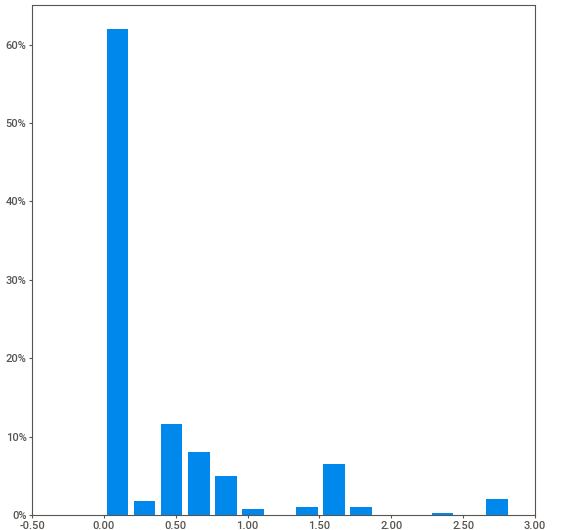
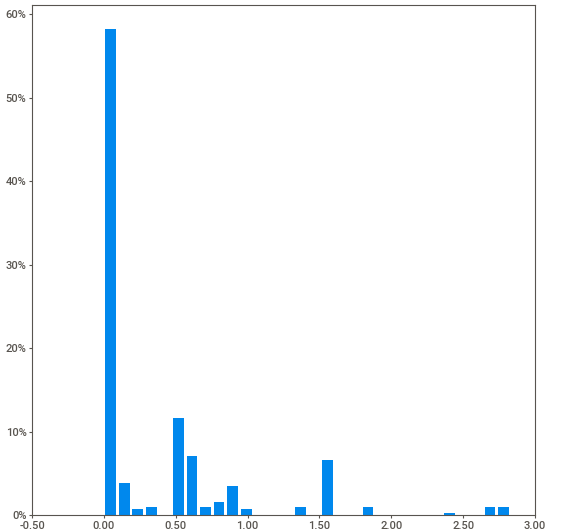
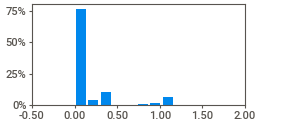
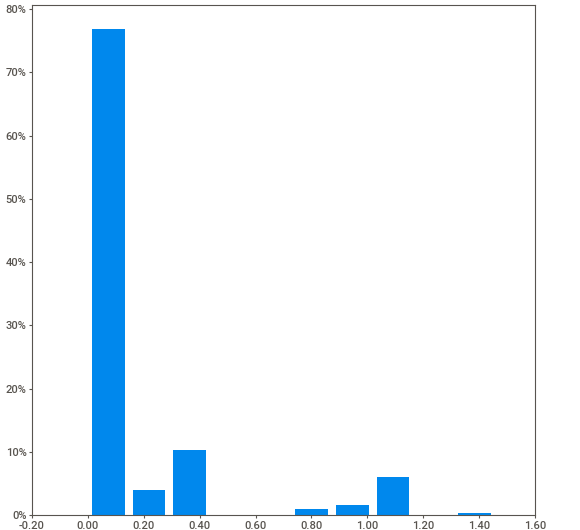
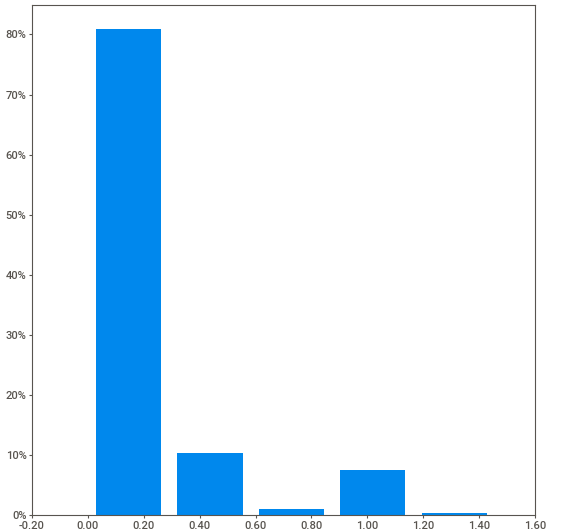
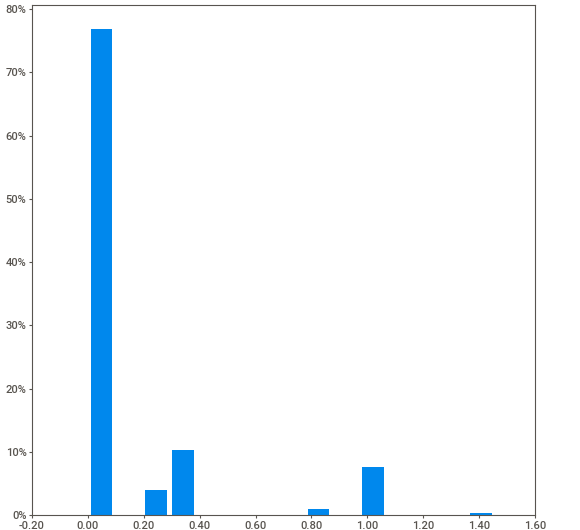
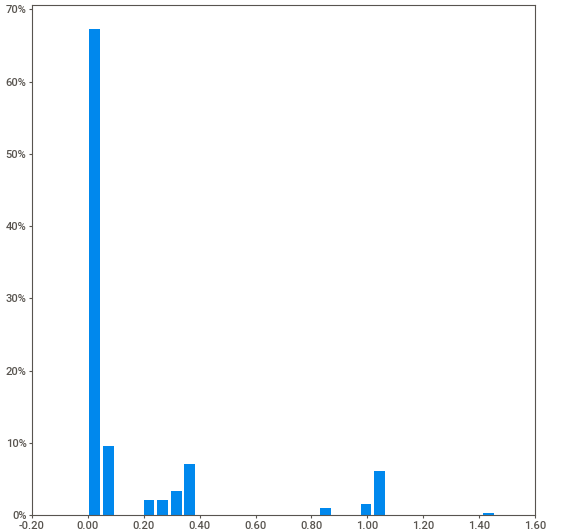
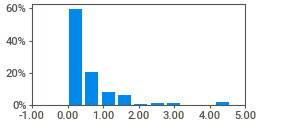
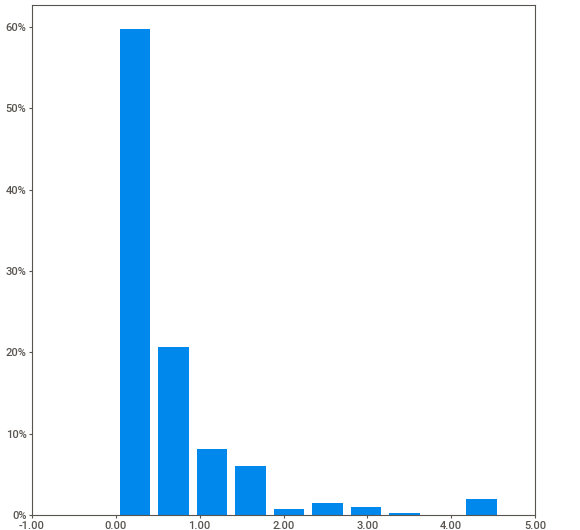
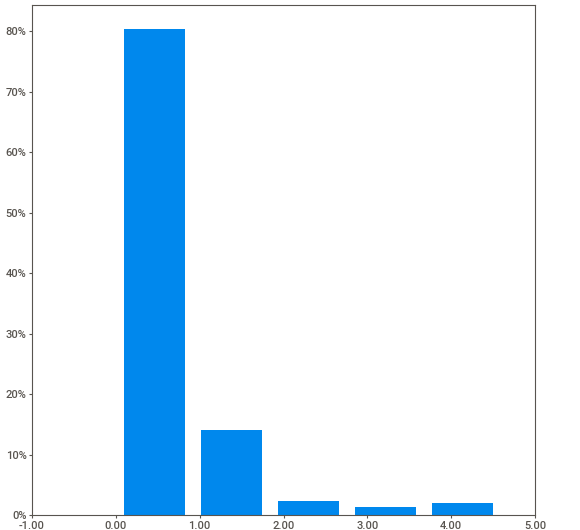
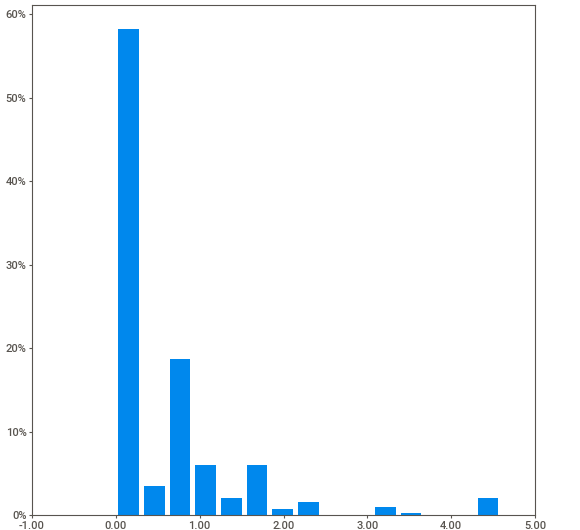
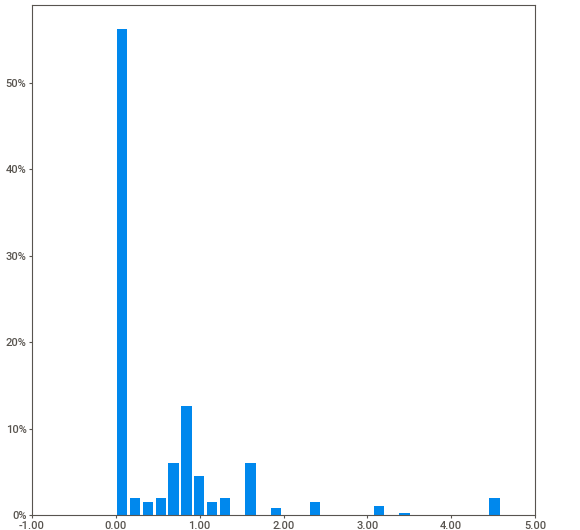
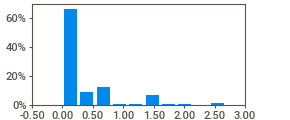
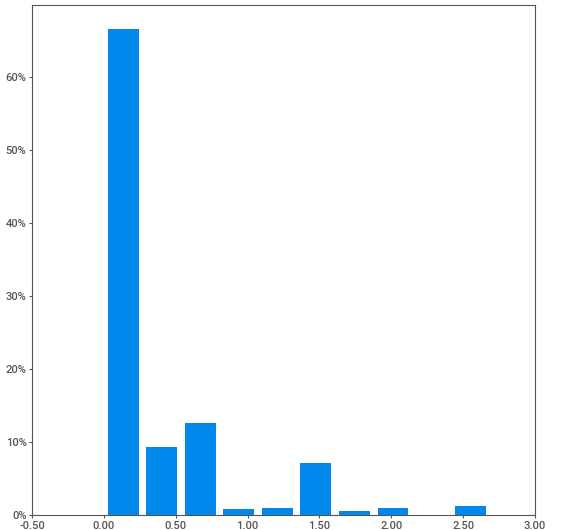
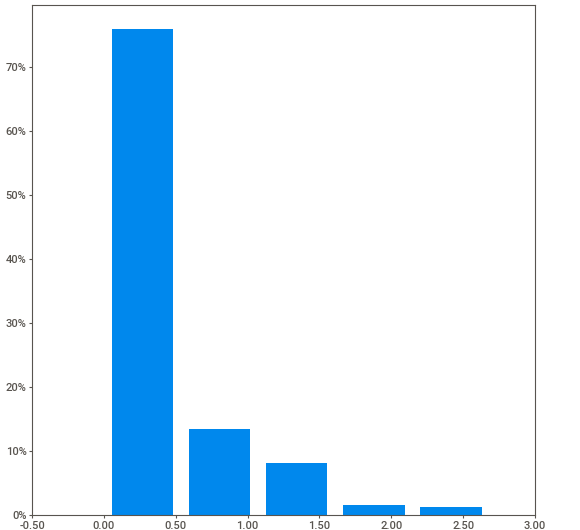
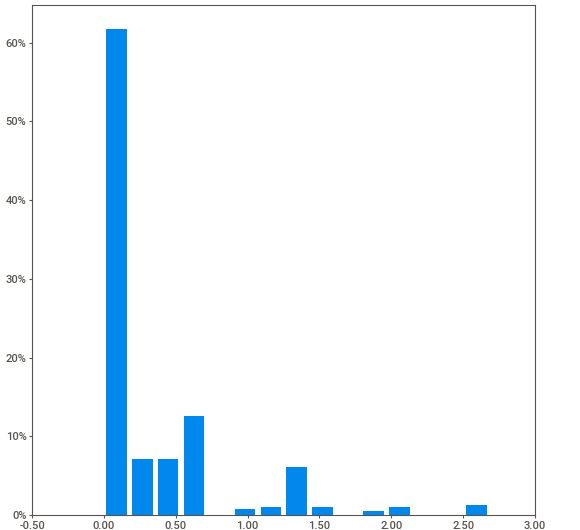
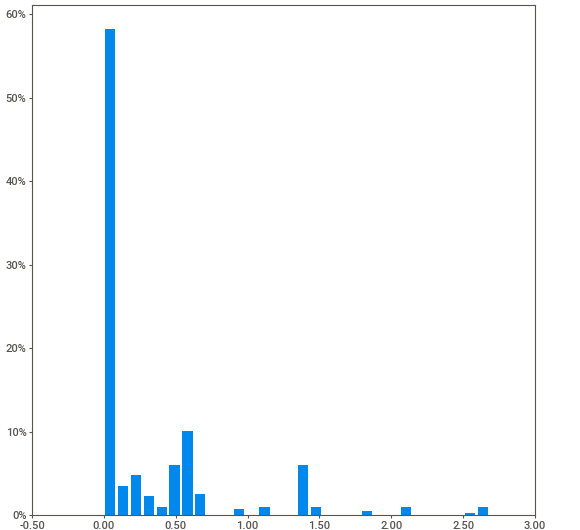
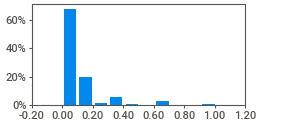
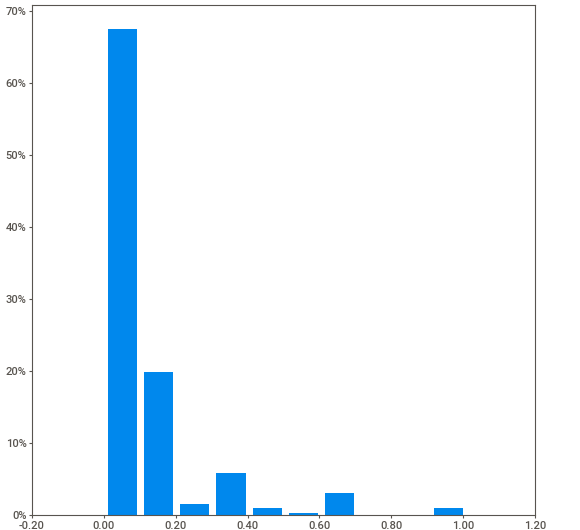
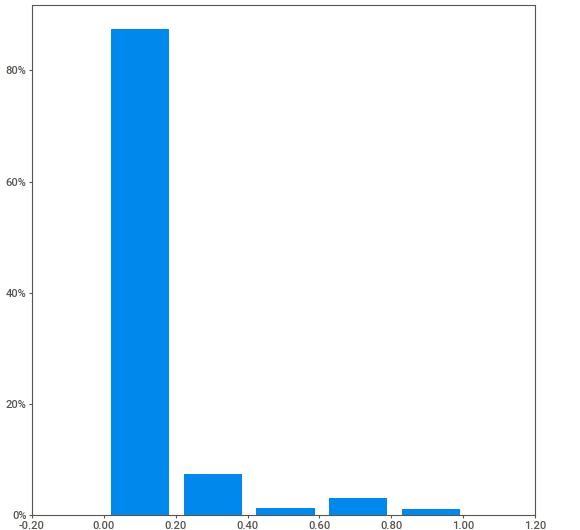
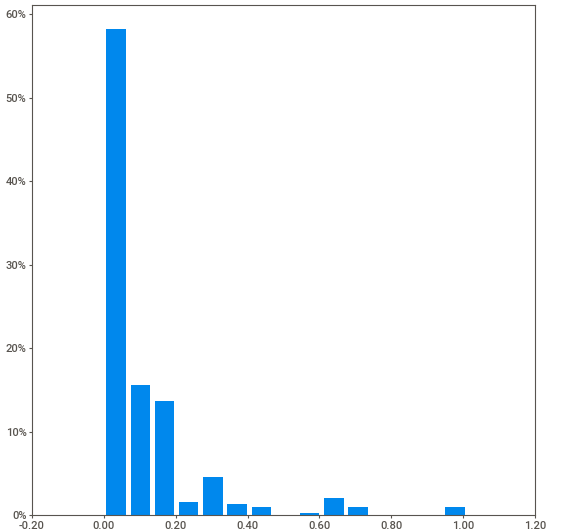
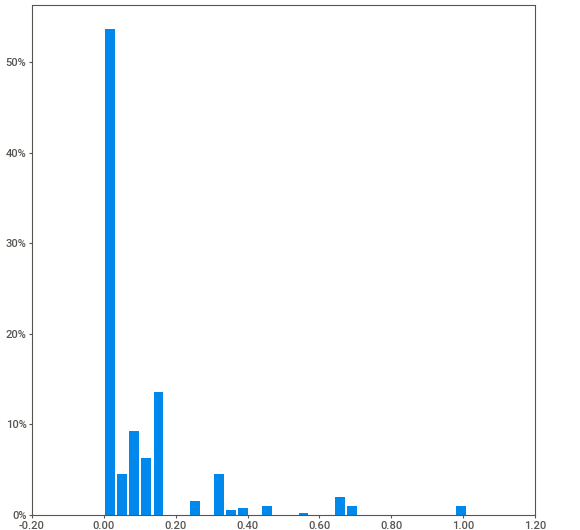
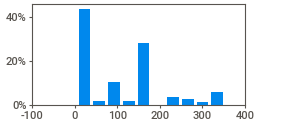
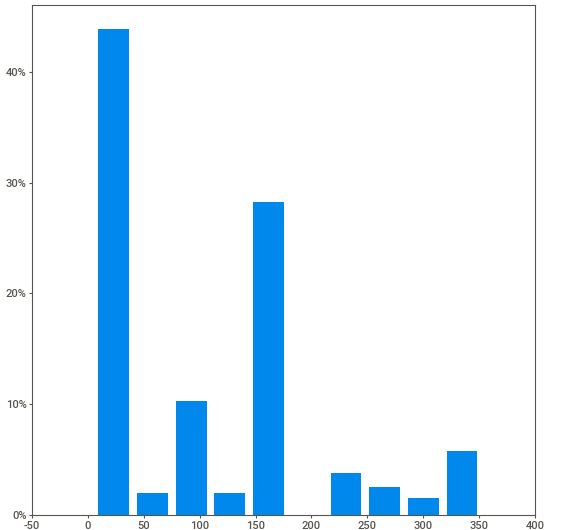
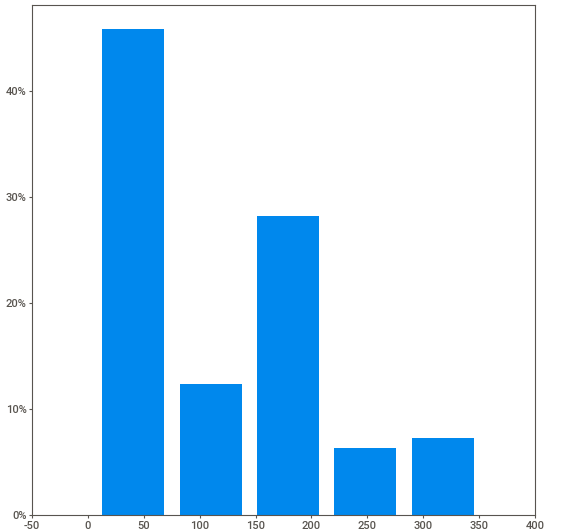
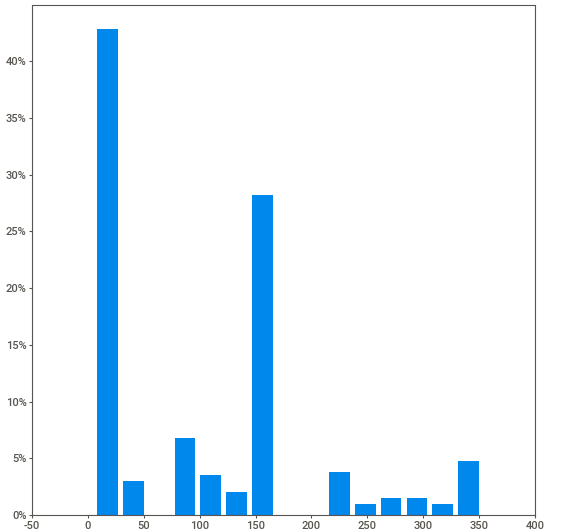
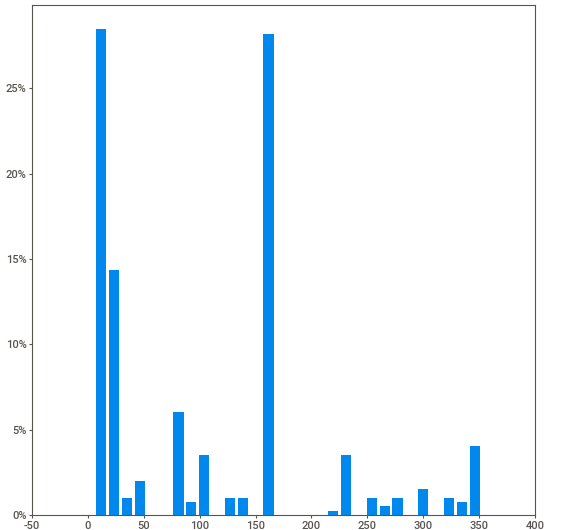
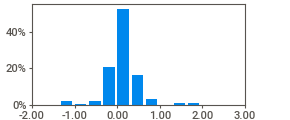
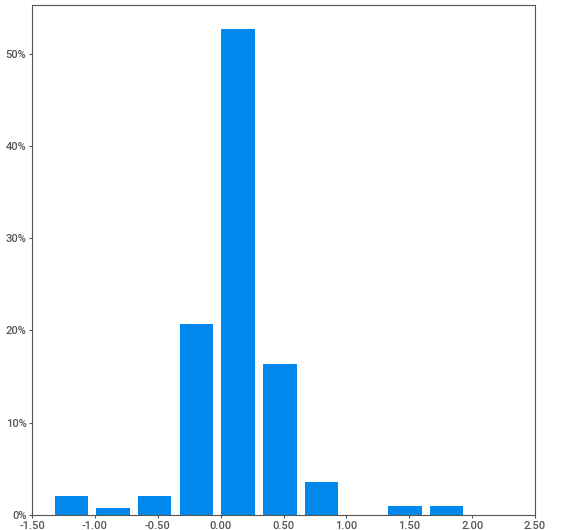
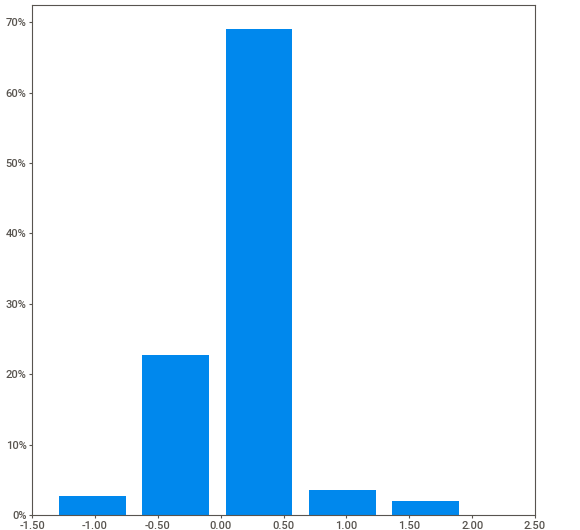
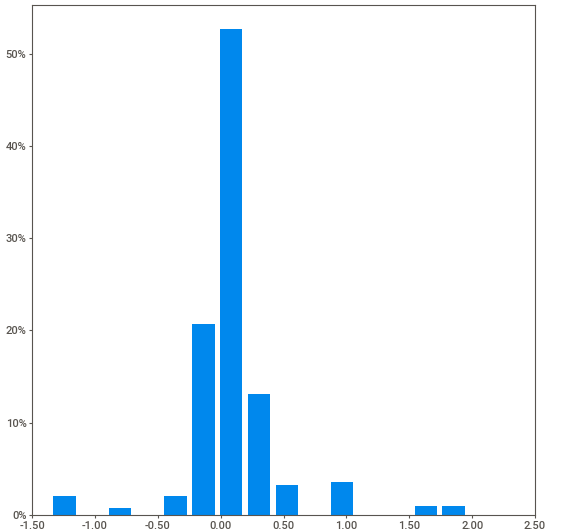
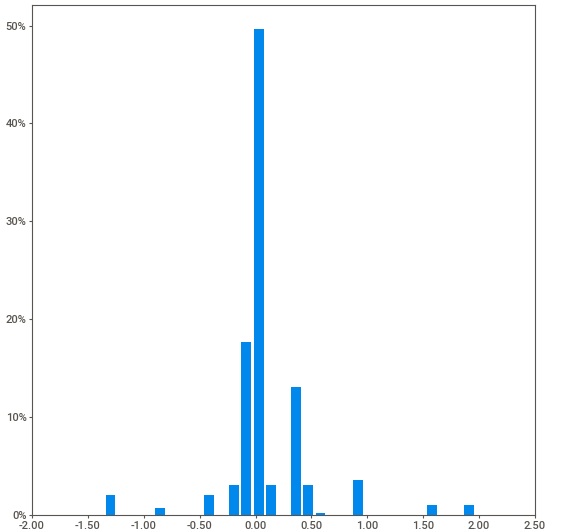
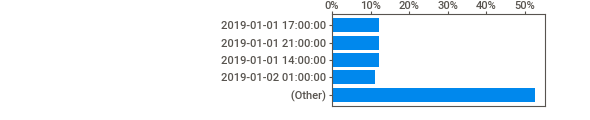
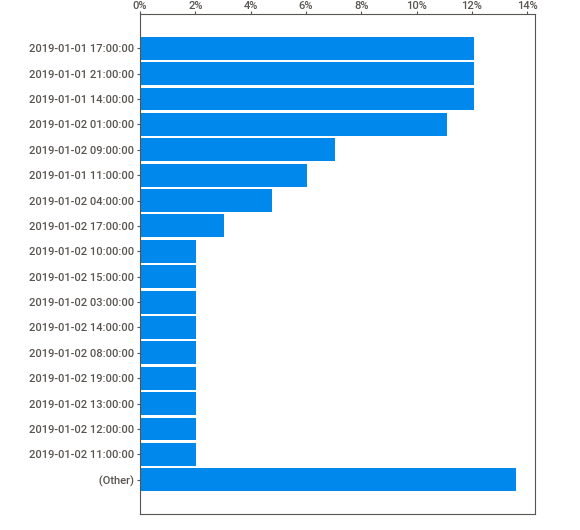
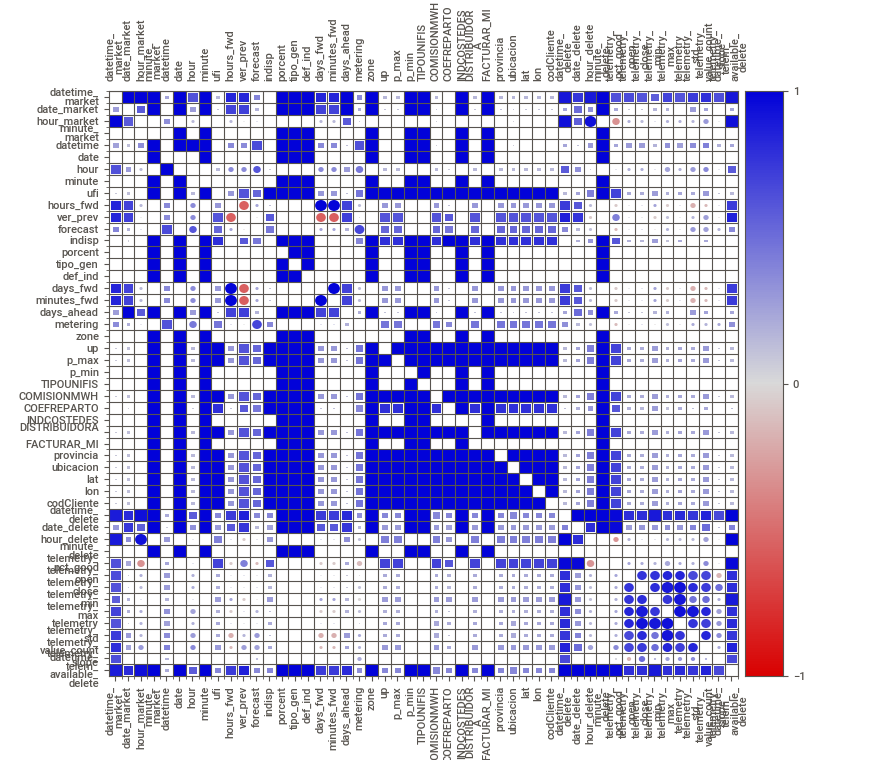
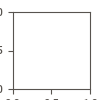

TypeError: 'NoneType' object is not callable

In [26]:
#display the report
advert_report.show_notebook()('premaster.html')

In [62]:
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import libpysal as lps
import mapclassify as mc
import esda
import numpy as np
import seaborn as sbn

In [63]:
gdf = gpd.read_file('data/map.geojson')
gdf = gdf[~gdf["name"].isin(["Santa Cruz De Tenerife","Las Palmas","Illes Balears"])]

In [64]:
geometry = [Point(xy) for xy in zip(master["lon"], master["lat"])]
crs = {'init': 'epsg:4326'}
master_gdf = GeoDataFrame(master, crs=crs, geometry=geometry)

Select ufis with location in Spain (otherwise they have faulty data)

In [65]:
# ufis_in_spain = gpd.sjoin(master_gdf[["ufi","geometry"]].drop_duplicates(), gdf, how='left', op='covered_by', lsuffix='left', rsuffix='right')
# ufis_not_in_spain = ufis_in_spain[ufis_in_spain["cod_ccaa"].isnull()]["ufi"]
ufis_not_in_spain = ["CARRACE","PESLOB","PESLOA","CADEIR","SASDON","PEAPAS","COMES","SASDOI","PESLOC","NEDAPE","AMPLESC","PESLOD","GRAIADE","PICADOR","AZUBIAS"]
master_gdf = master_gdf[~master_gdf["ufi"].isin(ufis_not_in_spain)]

In [66]:
master_gdf

datetime_market            datetime  hours_fwd      ufi  telemetry  \
72     2019-01-01 21:00:00 2019-01-02 00:00:00        3.0  TRAPERA   0.000000   
96     2019-01-02 01:00:00 2019-01-02 04:00:00        3.0  TRAPERA   0.000000   
116    2019-01-02 04:00:00 2019-01-02 07:00:00        3.0  TRAPERA        NaN   
133    2019-01-02 09:00:00 2019-01-02 12:00:00        3.0  TRAPERA   0.259893   
145    2019-01-02 17:00:00 2019-01-02 20:00:00        3.0  TRAPERA   0.174863   
...                    ...                 ...        ...      ...        ...   
527095 2022-10-30 19:00:00 2022-10-30 20:00:00        1.0  PELALIN        NaN   
527096 2022-10-30 20:00:00 2022-10-30 21:00:00        1.0  PELALIN        NaN   
527097 2022-10-30 21:00:00 2022-10-30 22:00:00        1.0  PELALIN        NaN   
527098 2022-10-30 22:00:00 2022-10-30 23:00:00        1.0  PELALIN        NaN   
527099 2022-10-29 23:00:00 2022-10-30 00:00:00        1.0  PELALIN        NaN   

        forecast  metering        lat    lon month_year  \
72           0.0     0.000  41.312000 -4.926    2019-01   
96           0.0     0.000  41.312000 -4.926    2019-01   
116          0.3     0.000  41.312000 -4.926    2019-01   
133          0.9     0.424  41.312000 -4.926    2019-01   
145          3.0     1.852  41.312000 -4.926    2019-01   
...          ...       ...        ...    ...        ...   
527095       0.4     0.871  42.661999 -8.110    2022-10   
527096       0.8     1.261  42.661999 -8.110    2022-10   
527097       1.3     1.866  42.661999 -8.110    2022-10   
527098       1.7     2.252  42.661999 -8.110    2022-10   
527099       1.5     1.631  42.661999 -8.110    2022-10   

                         geometry  
72      POINT (-4.92600 41.31200)  
96      POINT (-4.92600 41.31200)  
116     POINT (-4.92600 41.31200)  
133     POINT (-4.92600 41.31200)  
145     POINT (-4.92600 41.31200)  
...                           ...  
527095  POINT (-8.11000 42.66200)  
527096  POINT (-8.11000 42.66200)  
527097  POINT (-8.11000 42.66200)  
527098  POINT (-8.11000 42.66200)  
527099  POINT (-8.11000 42.66200)  

[5982098 rows x 11 columns]

In [ ]:
master

In [68]:
master_gdf["ufi"].nunique()

60

In [69]:
# Original
# master_gdf['metering'] = master_gdf['metering'].astype('float32')
# sj_gdf = gpd.sjoin(gdf, master_gdf, how='inner', op='intersects', lsuffix='left', rsuffix='right')
# median_metering_gb = sj_gdf['metering'].groupby([sj_gdf['name']]).mean()
# median_metering_gb

master_gdf['metering'] = master_gdf['metering'].astype('float32')

median_metering_portfolio = master_gdf['metering'].groupby([master_gdf['ufi']]).mean()

In [70]:
median_metering_portfolio

ufi
ABELLA      5.654620
AEROGEN     0.204223
ARTEIXO     0.439768
ASNEVES     0.612831
ATALAYA    11.825397
AXIABRE    10.442628
BANDELE     7.823181
BAYO       11.986115
BRULLES    13.441370
CALERA      0.917986
CAMPANA     1.225261
CERCEDA     0.835639
CERROS      1.261968
CPELAOS     0.713565
DEFERII     3.214736
DEHEII     11.417050
DEHESII    11.402614
ELGALLO    15.582618
ELLLAN     13.901299
ESCANDO     7.642351
ESE         0.136387
ESQUILE    11.627823
FEIXOS      1.918312
FRAILA      1.009150
HINOJAI     3.548437
HINOJII     2.285574
LACAYA      1.394975
LALOMBA     1.193213
LAMESA      1.375641
LARUYA      0.224535
LASORDA     1.680459
MONDONE    12.456623
MONTCEO     0.530098
MONTERO     5.785087
MONTOUT    11.393632
MUDEFER    10.536544
OTERO       1.128144
PAXAMON     9.674933
PEARBO      0.757110
PECORTI     8.893115
PECOUTE     2.321057
PEIRIXO     6.772663
PELALIN     0.865178
PELALOM    10.204827
PEOCHAO     2.492617
PEOUROL     5.933158
PEZARZU    12.620175
POTRA    

In [71]:
master_gdf = master_gdf.join(median_metering_portfolio, on='ufi', rsuffix="_median")
master_gdf = master_gdf[["ufi","geometry","metering_median"]].drop_duplicates()

In [72]:
master_gdf

ufi                   geometry  metering_median
72      TRAPERA  POINT (-4.92600 41.31200)         2.121338
306         ESE  POINT (-5.59900 36.01900)         0.136387
540     PELALIN  POINT (-8.11000 42.66200)         0.865178
774     TIGUEIR  POINT (-8.34800 42.61200)         0.995002
1008    ZARZUEL  POINT (-5.58500 36.05300)         4.213585
1242      VISOS  POINT (-1.41400 41.69300)        10.617264
1476     ROMERA  POINT (-1.72200 38.92800)         2.777313
1710    HINOJAI  POINT (-5.58500 36.05300)         3.548437
1944       BAYO  POINT (-1.30000 41.79400)        11.986115
2178     LARUYA  POINT (-2.02100 41.46100)         0.224535
2412    MONTCEO  POINT (-8.44300 42.39200)         0.530098
2646    ZAPATER  POINT (-4.06900 42.21700)        16.424580
2880    PECORTI  POINT (-6.05700 36.49900)         8.893115
3114    ASNEVES  POINT (-8.41600 42.08900)         0.612831
3348    MONTERO  POINT (-1.27300 41.78600)         5.785087
3816    LASORDA  POINT (-1.76400 42.58400)         1.680459
4050     LAMESA  POINT (-3.78000 42.78100)         1.375641
4752     FRAILA  POINT (-1.64400 42.48100)         1.009150
4986    DEHESII  POINT (-4.78000 41.91400)        11.402614
5220    CPELAOS  POINT (-3.62500 37.02900)         0.713565
5454     LACAYA  POINT (-1.64400 42.48100)         1.394975
5688      OTERO  POINT (-3.78000 42.78100)         1.128144
6390    PECOUTE  POINT (-7.63600 43.55900)         2.321057
6624    ELGALLO  POINT (-4.06900 42.21700)        15.582618
6858     DEHEII  POINT (-4.78000 41.91400)        11.417050
7092    MUDEFER   POINT (0.24300 41.04500)        10.536544
7326    BRULLES  POINT (-3.87000 42.57300)        13.441370
7560    SPADRON  POINT (-8.66000 42.74100)         0.400406
8262    AXIABRE  POINT (-8.72300 42.66700)        10.442628
8496    HINOJII  POINT (-5.58500 36.05300)         2.285574
8730     CERROS  POINT (-1.62300 42.65100)         1.261968
8964    PEZARZU  POINT (-4.06900 42.21700)        12.620175
9198      POTRA   POINT (0.92900 41.14700)         0.504260
9432    VILACHA  POINT (-7.63600 43.55900)         2.336721
9666    ESCANDO  POINT (-6.66200 38.74200)         7.642351
9900    ESQUILE  POINT (-4.78000 41.91100)        11.627823
10134   ATALAYA  POINT (-1.25100 41.82900)        11.825397
10368   MONDONE  POINT (-7.36200 43.43200)        12.456623
10602   SABUCED  POINT (-7.63600 43.55900)         4.837002
10836   BANDELE  POINT (-5.83200 41.14800)         7.823181
11070   AEROGEN  POINT (-0.49700 41.42600)         0.204223
11304   SANJOSE  POINT (-2.95000 37.18200)         0.408106
11538   CAMPANA  POINT (-1.64600 42.56600)         1.225261
11772   ARTEIXO  POINT (-8.51100 43.30600)         0.439768
12006   CERCEDA  POINT (-8.39400 43.29200)         0.835639
12240   PEOUROL  POINT (-7.63600 43.55900)         5.933158
12474   PEIRIXO  POINT (-8.12200 42.51100)         6.772663
12942   LALOMBA  POINT (-2.07800 42.42600)         1.193213
13176   MONTOUT  POINT (-8.31700 42.11500)        11.393632
13410    RODERA  POINT (-5.83200 41.14800)         7.430479
13878   DEFERII   POINT (0.24300 41.04500)         3.214736
14112   PEOCHAO  POINT (-7.72200 43.46900)         2.492617
14346    FEIXOS   POINT (0.92900 41.14700)         1.918312
14580    CALERA  POINT (-1.72700 42.66600)         0.917986
14814   PELALOM  POINT (-0.70700 40.67300)        10.204827
15048    PEARBO  POINT (-8.31700 42.11500)         0.757110
15516   SERRETA  POINT (-1.28100 41.69000)        12.150781
13176    ELLLAN  POINT (-1.30000 41.79400)        13.901299
15282    ABELLA  POINT (-7.29000 42.76200)         5.654620
258876  PAXAMON  POINT (-8.99200 42.94200)         9.674933

In [11]:
# gdf = gdf.join(median_metering_gb, on='name')
# gdf.rename(columns={'metering': 'median_metering'}, inplace=True)
# gdf.head(15)

In [15]:
# gdf['median_metering'] = gdf['median_metering'].fillna((gdf['median_metering'].mean()))
# gdf = gdf[gdf["name"] != "Santa Cruz De Tenerife"]
# gdf = gdf[gdf["name"] != "Las Palmas"]

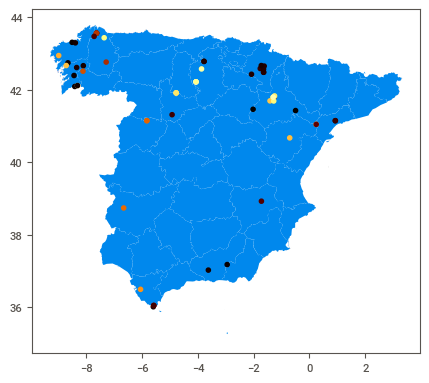

In [73]:
# master_gdf.plot(column='metering_median')

f, ax = plt.subplots(1, figsize=(5, 5))
ax = gdf.plot(ax=ax)
ax = master_gdf.plot(column='metering_median', cmap='afmhot' ,ax=ax)
# ax.set_xlim([-125, -67])
# ax.set_ylim([24, 50])
plt.show()


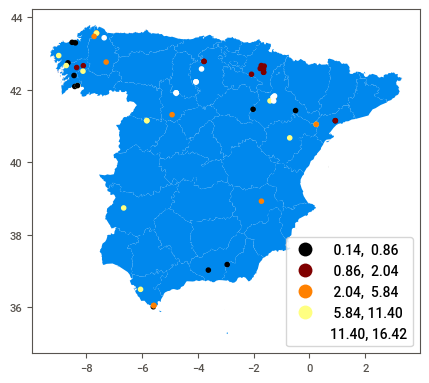

In [74]:
# fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
# gdf.plot(column='median_metering', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)
# #ax.set_xlim(150000, 160000)
# #ax.set_ylim(208000, 215000)

fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'aspect':'equal'})
ax = gdf.plot(ax=ax)
ax = master_gdf.plot(column='metering_median', scheme='Quantiles', k=5, legend=True, cmap='afmhot' ,ax=ax)
plt.show()


## Spatial Autocorrelation

The concept of spatial autocorrelation relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

Let’s use PySAL to generate these two types of similarity measures.

## Spatial Similarity
We have already encountered spatial weights in a previous notebook. In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity. As we have seen there are many ways to define spatial weights, here we will use queen contiguity:

In [122]:
df = master_gdf
# https://pysal.org/libpysal/generated/libpysal.weights.Kernel.html#libpysal.weights.Kernel
wq =  lps.weights.Kernel.from_dataframe(df, k=2)
wq.transform = 'r'

## Attribute Similarity
So the spatial weight between neighborhoods i and j indicates if the two are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For neighborhood  the spatial lag is defined as:

FORMULA

In [123]:
y = df['metering_median']
ylag = lps.weights.lag_spatial(wq, y)

In [139]:
ylagq5 = mc.Quantiles(ylag, k=3)

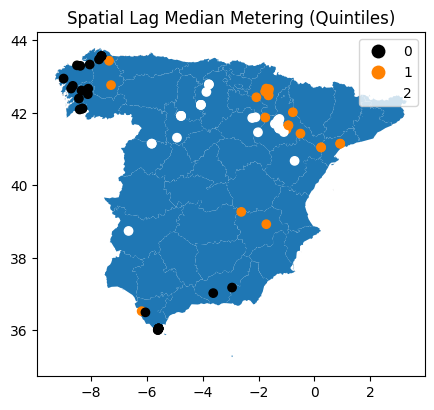

In [140]:

# df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
#         k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
#         edgecolor='white', legend=True)
# ax.set_axis_off()
# plt.title("Spatial Lag Median Metering (Quintiles)")

# plt.show()

fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'aspect':'equal'})
ax = gdf.plot(ax=ax)
# ax = master_gdf.plot(column='metering_median', scheme='Quantiles', k=5, legend=True, cmap='afmhot' ,ax=ax)
ax = df.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, k=3, legend=True, cmap='afmhot' ,ax=ax)
plt.title("Spatial Lag Median Metering (Quintiles)")
plt.show()


## Global Spatial Autocorrelation
We begin with a simple case where the variable under consideration is binary. This is useful to unpack the logic of spatial autocorrelation tests. So even though our attribute is a continuously valued one, we will convert it to a binary case to illustrate the key concepts:

In [141]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb]
df['yb'] = yb

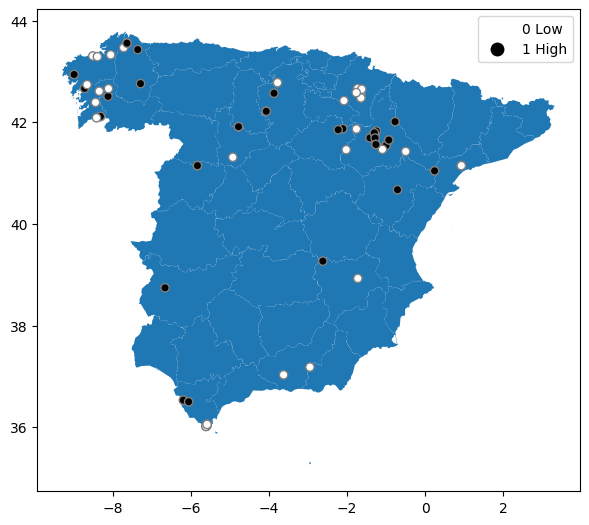

In [152]:
# fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
# df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

fig, ax = plt.subplots(figsize=(7,7), subplot_kw={'aspect':'equal'})
ax = gdf.plot(ax=ax)
ax = df.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)
plt.show()

## Join counts
One way to formalize a test for spatial autocorrelation in a binary attribute is to consider the so-called joins. A join exists for each neighbor pair of observations, and the joins are reflected in our binary spatial weights object wq.

Each unit can take on one of two values “Black” or “White”, and so for a given pair of neighboring locations there are three different types of joins that can arise:

Black Black (BB)

White White (WW)

Black White (or White Black) (BW)

Given that we have 68 Black polygons on our map, what is the number of Black Black (BB) joins we could expect if the process were such that the Black polygons were randomly assigned on the map? This is the logic of join count statistics.

We can use the esda package from PySAL to carry out join count analysis:

In [153]:
yb = 1 * (y > y.median()) # convert back to binary
# wq =  lps.weights.Queen.from_dataframe(df)
wq =  lps.weights.Kernel.from_dataframe(df, k=2)
wq.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, wq)

The resulting object stores the observed counts for the different types of joins:

In [154]:
jc.bb

230.5

In [155]:
jc.ww

211.0

In [156]:
jc.bw

390.0

Note that the three cases exhaust all possibilities:

In [157]:
jc.bb + jc.ww + jc.bw

831.5

and

In [158]:
wq.s0 / 2

831.5

which is the unique number of joins in the spatial weights object.

Our object tells us we have observed 230 BB joins:

The critical question for us, is whether this is a departure from what we would expect if the process generating the spatial distribution of the Black polygons were a completely random one? To answer this, PySAL uses random spatial permutations of the observed attribute values to generate a realization under the null of complete spatial randomness (CSR). This is repeated a large number of times (999 default) to construct a reference distribution to evaluate the statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [159]:
jc.mean_bb

210.61711711711712

which is less than our observed count. The question is whether our observed value is so different from the expectation that we would reject the null of CSR?

Text(0.5, 0, 'BB Counts')

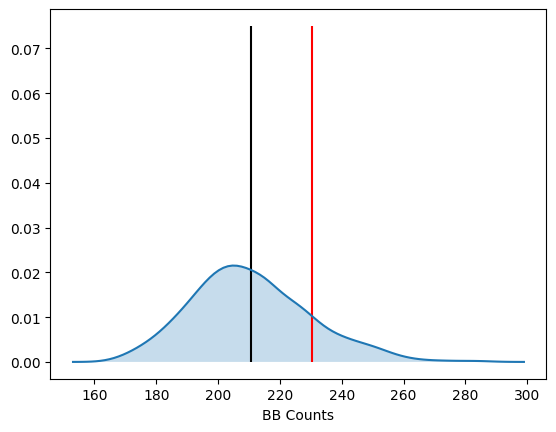

In [160]:
sbn.kdeplot(jc.sim_bb, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

The density portrays the distribution of the BB counts, with the black vertical line indicating the mean BB count from the synthetic realizations and the red line the observed BB count for our prices. Clearly our observed value is extremely high. A pseudo p-value summarizes this:

In [161]:
jc.p_sim_bb

0.153

Since this is below conventional significance levels, we would reject the null of complete spatial randomness in favor of spatial autocorrelation in market prices.

## Continuous Case
The join count analysis is based on a binary attribute, which can cover many interesting empirical applications where one is interested in presence and absence type phenomena. In our case, we artificially created the binary variable, and in the process we throw away a lot of information in our originally continuous attribute. Turning back to the original variable, we can explore other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [162]:
wq.transform = 'r'

In [163]:
y = df['metering_median']

In [164]:
np.random.seed(12345)
mi = esda.moran.Moran(y, wq)
mi.I

0.2409576608522766

Text(0.5, 0, "Moran's I")

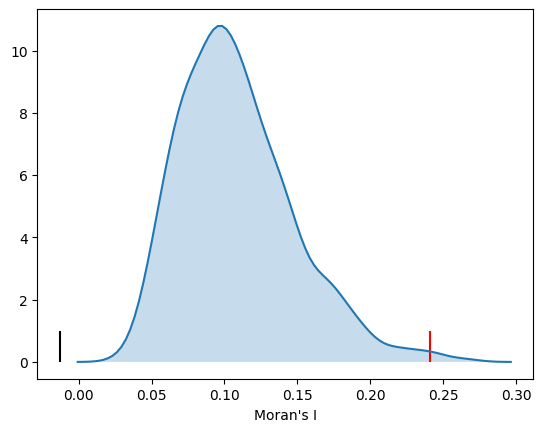

In [165]:

sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")


In [166]:
mi.p_sim

0.007

## Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers
In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let’s compute a local Moran statistic for the same d

In [206]:
wq.transform = 'r'
lag_metering = lps.weights.lag_spatial(wq, df['metering_median'])

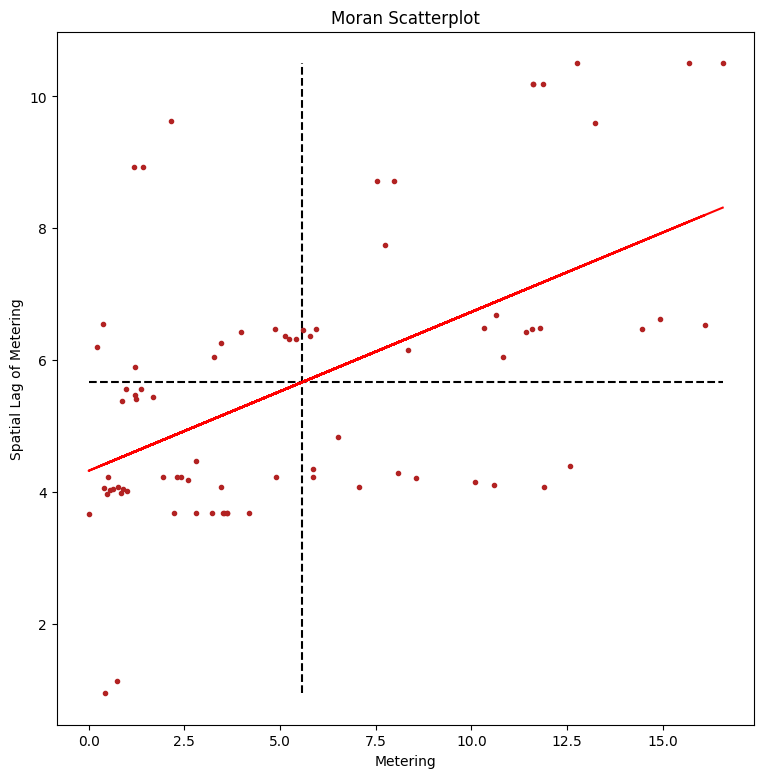

In [207]:
metering = df['metering_median']
b, a = np.polyfit(metering, lag_metering, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(metering, lag_metering, '.', color='firebrick')

 # dashed vert at mean of the price
plt.vlines(metering.mean(), lag_metering.min(), lag_metering.max(), linestyle='--')
 # dashed horizontal at mean of lagged price
plt.hlines(lag_metering.mean(), metering.min(), metering.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(metering, a + b*metering, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of Metering')
plt.xlabel('Metering')
plt.show()

In [208]:
li = esda.moran.Moran_Local(y, wq)

In [209]:
li.q

array([1, 3, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 1, 2, 1, 3, 3, 3, 2, 3, 3, 4,
       3, 1, 3, 1, 4, 2, 2, 2, 3, 2, 3, 2, 3, 1, 4, 1, 1, 3, 1, 4, 3, 4,
       1, 3, 3, 3, 1, 1, 3, 1, 2, 1, 2, 4, 2, 3, 2, 4, 3, 1, 1, 2, 2, 1,
       3, 1, 3, 1, 3, 1, 3, 1, 3, 3, 1, 1, 3])

We can again test for local clustering using permutations, but here we use conditional random permutations (different distributions for each focal location)

In [210]:
(li.p_sim < 0.05).sum()

17

In [211]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [212]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

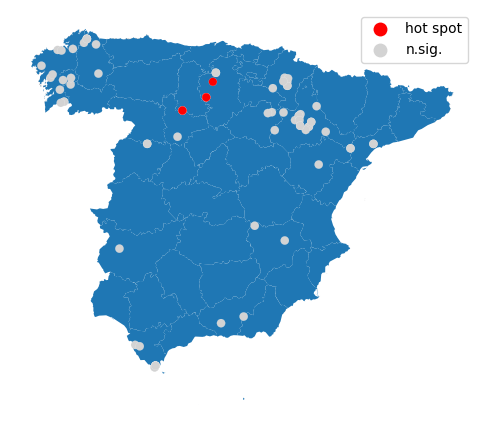

In [218]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
ax = gdf.plot(ax=ax)
ax = df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()


In [220]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

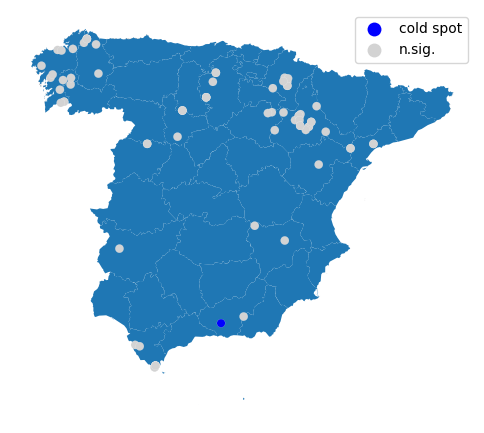

In [222]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
ax = gdf.plot(ax=ax)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [223]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

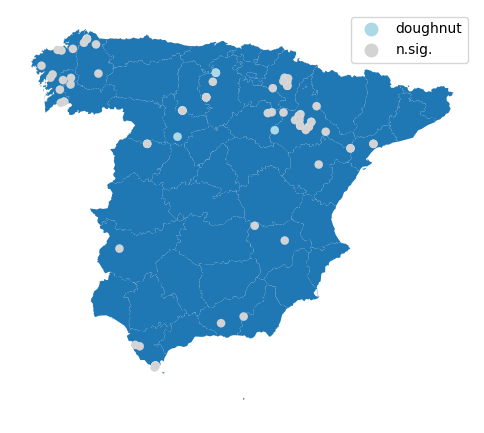

In [224]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
ax = gdf.plot(ax=ax)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [225]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

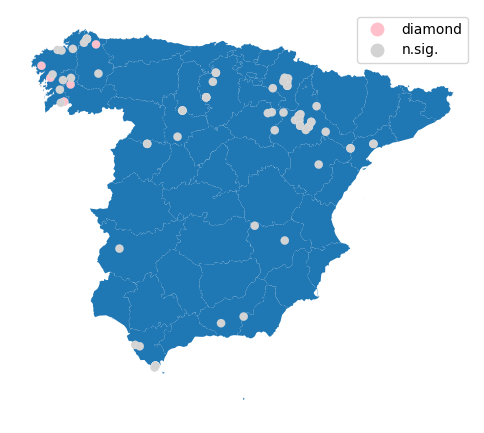

In [226]:
df = df
from matplotlib import colors
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(6, 6))
ax = gdf.plot(ax=ax)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [227]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([1, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 4, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 4, 0, 0, 2, 4, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0])

In [228]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

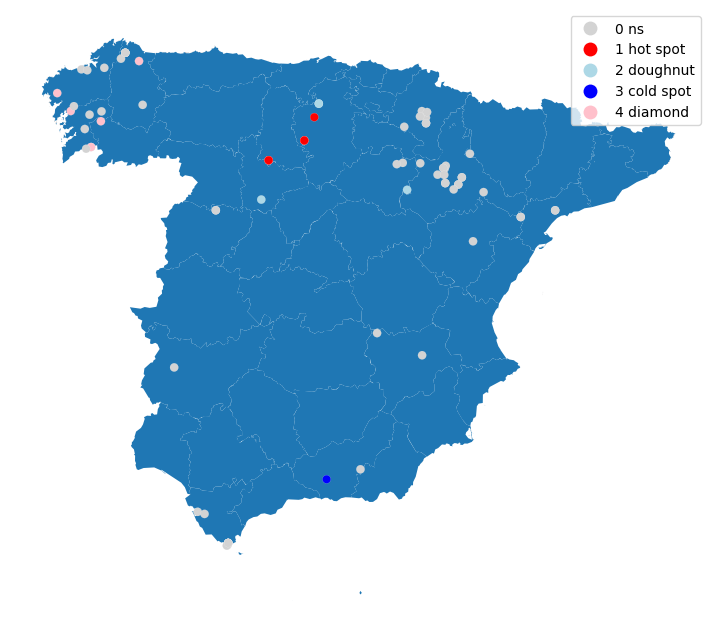

In [229]:

from matplotlib import colors
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
ax = gdf.plot(ax=ax)
df.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()